# Vector-space models: retrofitting

In [10]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Fall 2020"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [The retrofitting model](#The-retrofitting-model)
1. [Examples](#Examples)
  1. [Only node 0 has outgoing edges](#Only-node-0-has-outgoing-edges)
  1. [All nodes connected to all others](#All-nodes-connected-to-all-others)
  1. [As before, but now 2 has no outgoing edges](#As-before,-but-now-2-has-no-outgoing-edges)
  1. [All nodes connected to all others, but $\alpha = 0$](#All-nodes-connected-to-all-others,-but-$\alpha-=-0$)
1. [WordNet](#WordNet)
  1. [Background on WordNet](#Background-on-WordNet)
  1. [WordNet and VSMs](#WordNet-and-VSMs)
  1. [Reproducing the WordNet synonym graph experiment](#Reproducing-the-WordNet-synonym-graph-experiment)
1. [Other retrofitting models and ideas](#Other-retrofitting-models-and-ideas)

## Overview

* Thus far, all of the information in our word vectors has come solely from co-occurrences patterns in text. This information is often very easy to obtain – though one does need a __lot__ of text – and it is striking how rich the resulting representations can be.

* Nonetheless, it seems clear that there is important information that we will miss this way – relationships that just aren't encoded at all in co-occurrences or that get distorted by such patterns. 

* For example, it is probably straightforward to learn representations that will support the inference that all puppies are dogs (_puppy_ entails _dog_), but it might be difficult to learn that _dog_ entails _mammal_ because of the unusual way that very broad taxonomic terms like _mammal_ are used in text.

* The question then arises: how can we bring structured information – labels – into our representations? If we can do that, then we might get the best of both worlds: the ease of using co-occurrence data and the refinement that comes from using labeled data.

* In this notebook, we look at one powerful method for doing this: the __retrofitting__ model of [Faruqui et al. 2016](http://www.aclweb.org/anthology/N15-1184). In this model, one learns (or just downloads) distributed representations for nodes in a knowledge graph and then updates those representations to bring connected nodes closer to each other.

* This is an incredibly fertile idea; the final section of the notebook reviews some recent extensions, and new ones are likely appearing all the time.

## Set-up

In [11]:
%matplotlib inline
from collections import defaultdict
from nltk.corpus import wordnet as wn
import numpy as np
import os
import pandas as pd
import retrofitting
from retrofitting import Retrofitter
import utils

In [12]:
data_home = 'data'

## The retrofitting model

For an __an existing VSM__ $\widehat{Q}$ of dimension $m \times n$, and a set of __edges__  $E$ (pairs of indices into rows in  $\widehat{Q}$), the retrofitting objective is to obtain a new VSM $Q$ (also dimension $m \times n$)  according to the following objective:

$$\sum_{i=1}^{m} \left[ 
\alpha_{i}\|q_{i} - \widehat{q}_{i}\|_{2}^{2}
+
\sum_{j : (i,j) \in E}\beta_{ij}\|q_{i} - q_{j}\|_{2}^{2}
\right]$$

The left term encodes a pressure to stay like the original vector. The right term encodes a pressure to be more like one's neighbors. In minimizing this objective, we should be able to strike a balance between old and new, VSM and graph.

Definitions:

1. $\|u - v\|_{2}^{2}$ gives the __squared euclidean distance__ from $u$ to $v$.

1. $\alpha$ and $\beta$ are weights we set by hand, controlling the relative strength of the two pressures. In the paper, they use $\alpha=1$ and $\beta = \frac{1}{\{j : (i, j) \in E\}}$.

## Examples

To get a feel for what's happening, it's helpful to visualize the changes that occur in small, easily understood VSMs and graphs. The function `retrofitting.plot_retro_path` helps with this.

In [13]:
Q_hat = pd.DataFrame(
    [[0.0, 0.0],
     [0.0, 0.5],
     [0.5, 0.0]],
    columns=['x', 'y'])

Q_hat

,x,y
0,0.0,0.0
1,0.0,0.5
2,0.5,0.0


### Only node 0 has outgoing edges

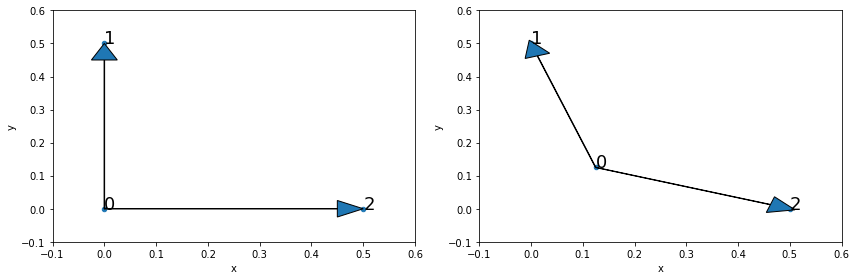

In [14]:
edges_0 = {0: {1, 2}, 1: set(), 2: set()}

_ = retrofitting.plot_retro_path(Q_hat, edges_0)

### All nodes connected to all others

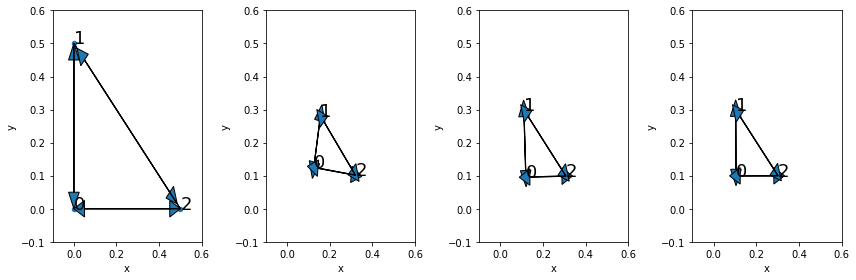

In [15]:
edges_all = {0: {1, 2}, 1: {0, 2}, 2: {0, 1}}

_ = retrofitting.plot_retro_path(Q_hat, edges_all)

### As before, but now 2 has no outgoing edges

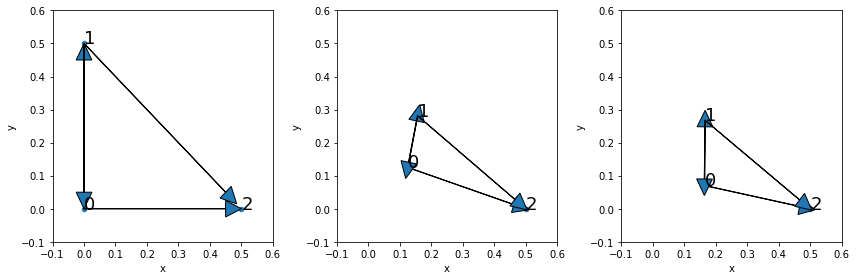

In [16]:
edges_isolated = {0: {1, 2}, 1: {0, 2}, 2: set()}

_ = retrofitting.plot_retro_path(Q_hat, edges_isolated)

### All nodes connected to all others, but $\alpha = 0$

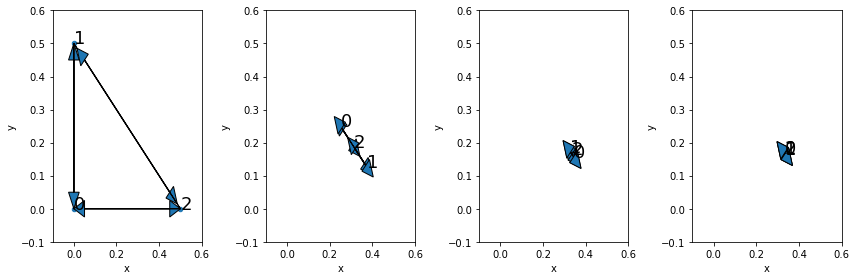

In [17]:
_ = retrofitting.plot_retro_path(
    Q_hat, edges_all,
    retrofitter=Retrofitter(alpha=lambda x: 0))

## WordNet

Faruqui et al. conduct experiments on three knowledge graphs: [WordNet](https://wordnet.princeton.edu), [FrameNet](https://framenet.icsi.berkeley.edu/fndrupal/), and the [Penn Paraphrase Database (PPDB)](http://paraphrase.org/). [The repository for their paper](https://github.com/mfaruqui/retrofitting) includes the graphs that they derived for their experiments.

Here, we'll reproduce just one of the two WordNet experiments they report, in which the graph is formed based on synonymy.

### Background on WordNet

WordNet is an incredible, hand-built lexical resource capturing a wealth of information about English words and their inter-relationships. ([Here is a collection of WordNets in other languages.](http://globalwordnet.org)) For a detailed overview using NLTK, see [this tutorial](http://compprag.christopherpotts.net/wordnet.html).

The core concepts:

* A __lemma__ is something like our usual notion of __word__. Lemmas are highly sense-disambiguated. For instance, there are six lemmas that are consistent with the string `crane`: the bird, the machine, the poets, ...

* A __synset__ is a collection of lemmas that are synonymous in the WordNet sense (which is WordNet-specific; words with intuitively different meanings might still be grouped together into synsets.).

WordNet is a graph of relations between lemmas and between synsets, capturing things like hypernymy, antonymy, and many others. For the most part, the relations are defined between nouns; the graph is sparser for other areas of the lexicon.

In [19]:
!python -m nltk.downloader

/opt/anaconda3/envs/nlu/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [20]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/jonad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
lems = wn.lemmas('crane', pos=None)

for lem in lems:
    ss = lem.synset()
    print("="*70)
    print("Lemma name: {}".format(lem.name()))
    print("Lemma Synset: {}".format(ss))
    print("Synset definition: {}".format(ss.definition()))

Lemma name: Crane
Lemma Synset: Synset('crane.n.01')
Synset definition: United States writer (1871-1900)
Lemma name: Crane
Lemma Synset: Synset('crane.n.02')
Synset definition: United States poet (1899-1932)
Lemma name: Crane
Lemma Synset: Synset('grus.n.01')
Synset definition: a small constellation in the southern hemisphere near Phoenix
Lemma name: crane
Lemma Synset: Synset('crane.n.04')
Synset definition: lifts and moves heavy objects; lifting tackle is suspended from a pivoted boom that rotates around a vertical axis
Lemma name: crane
Lemma Synset: Synset('crane.n.05')
Synset definition: large long-necked wading bird of marshes and plains in many parts of the world
Lemma name: crane
Lemma Synset: Synset('crane.v.01')
Synset definition: stretch (the neck) so as to see better


### WordNet and VSMs

A central challenge of working with WordNet is that one doesn't usually encounter lemmas or synsets in the wild. One probably gets just strings, or maybe strings with part-of-speech tags. Mapping these objects to lemmas is incredibly difficult.

For our experiments with VSMs, we simply collapse together all the senses that a given string can have. This is expedient, of course. It might also be a good choice linguistically: senses are flexible and thus hard to individuate, and we might hope that our vectors can model multiple senses at the same time. 

(That said, there is excellent work on creating sense-vectors; see [Reisinger and Mooney 2010](http://www.aclweb.org/anthology/N10-1013); [Huang et al 2012](http://www.aclweb.org/anthology/P12-1092).)

The following code uses the NLTK WordNet API to create the edge dictionary we need for using the `Retrofitter` class:

In [38]:
def get_wordnet_edges():
    edges = defaultdict(set)
    for ss in wn.all_synsets():
        lem_names = {lem.name() for lem in ss.lemmas()}
        for lem in lem_names:
            edges[lem] |= lem_names
    return edges

In [48]:
edges = defaultdict(set)

In [49]:
edges

defaultdict(set, {})

In [59]:
edges['hello']  |= {'me'} 

In [60]:
edges

defaultdict(set, {'hello': {'me'}})

In [54]:
edges = defaultdict(set)
for ss in wn.all_synsets():
    #print(edges)
    lem_names = {lem.name() for lem in ss.lemmas()}
    for lem in lem_names:
        print(lem)
#         edges[lem] |= lem_names
#         print(edges)


able
unable
abaxial
dorsal
ventral
adaxial
acroscopic
basiscopic
abducent
abducting
adducent
adductive
adducting
nascent
emergent
emerging
dissilient
parturient
dying
moribund
last
abridged
shortened
cut
half-length
potted
unabridged
full-length
uncut
absolute
direct
implicit
unquestioning
infinite
living
comparative
relative
relational
absorptive
absorbent
sorbefacient
absorbefacient
assimilatory
assimilative
assimilating
hygroscopic
receptive
shock-absorbent
spongelike
spongy
thirsty
nonabsorbent
nonabsorptive
repellent
resistant
adsorbent
adsorptive
surface-assimilative
chemisorptive
chemosorptive
nonadsorbent
nonadsorptive
absorbable
adsorbate
adsorbable
abstemious
abstentious
abstinent
austere
ascetical
spartan
ascetic
gluttonous
crapulous
crapulent
crapulous
esurient
wolfish
ravening
ravenous
edacious
rapacious
voracious
greedy
swinish
piggy
piggish
porcine
hoggish
overgreedy
too-greedy
abstract
conceptional
ideational
notional
conceptual
ideal
ideologic
ideological
concrete
obje

retiring
self-effacing
reticent
associative
associatory
associable
nonassociative
committed
attached
betrothed
bespoken
intended
involved
uncommitted
unattached
unengaged
unpromised
unpledged
affixed
appendant
basifixed
glued
pasted
mounted
loose
unaffixed
sessile
stalkless
pedunculate
stalked
sessile
vagile
unattached
free-swimming
attached
detached
separate
freestanding
semidetached
stuck
cragfast
unstuck
attachable
bindable
bondable
clip-on
tie-on
detachable
clastic
wary
on_one's_guard
on_guard
on_your_guard
upon_one's_guard
shy
unwary
gullible
unguarded
attentive
captive
intent
wrapped
enwrapped
engrossed
absorbed
advertent
heedful
observant
oversolicitous
solicitous
inattentive
abstracted
scatty
absentminded
absent
distracted
distrait
woolgathering
moony
dreamy
drowsy
yawning
oscitant
forgetful
oblivious
attractive
bewitching
entrancing
fascinating
enthralling
enchanting
captivating
charismatic
magnetic
cunning
cute
dinky
engaging
piquant
taking
fetching
winning
glossy
showy
spell

surefooted
sure-footed
confident
resourceful
incapable
unable
capable
incapable
cared-for
attended
tended_to
uncared-for
unattended
neglected
untended
careful
blow-by-blow
sure
certain
close
conscientious
painstaking
scrupulous
elaborate
elaborated
detailed
narrow
minute
too-careful
overcareful
particular
protective
studious
thorough
careless
casual
passing
perfunctory
cursory
slipshod
slapdash
haphazard
sloppy
reckless
heedless
incautious
offhanded
offhand
carnivorous
meat-eating
flesh-eating
zoophagous
piscivorous
predaceous
predacious
herbivorous
anthophagous
anthophilous
baccivorous
carpophagous
fruit-eating
grass-eating
phytophagous
plant-eating
phytophagic
phytophilous
saprozoic
saprophagous
saprophytic
omnivorous
all-devouring
insectivorous
apivorous
myrmecophagous
holozoic
holophytic
carpellate
pistillate
acarpellous
acarpelous
carpeted
uncarpeted
carvel-built
flush-seamed
clincher-built
lap-straked
lap-strake
clinker-built
lap-streak
lap-streaked
carved
carven
graven
inscribed

honey-colored
indigo
lead-coloured
lead-colored
liver-colored
liver
metallic-coloured
metal-colored
metal-coloured
metallic-colored
monochromous
monochrome
monochromic
monochromatic
particoloured
pied
multicoloured
calico
piebald
multi-coloured
multi-colored
multi-color
multicolored
multicolour
particolored
varicolored
multi-colour
motley
multicolor
varicoloured
painted
neutral-coloured
neutral-colored
olive-colored
olive-coloured
orange-colored
orange-coloured
orange-hued
orange-flowered
pale-hued
pale-colored
pastel-colored
peach-colored
polychromatic
polychrome
polychromic
purple-flowered
red-flowered
roan
rose-colored
rosy-colored
rust-colored
silver-colored
straw-colored
straw-coloured
tawny-coloured
tawny-colored
trichrome
trichromatic
tricolor
violet-flowered
violet-coloured
violet-colored
violet-purple
uncoloured
uncolored
achromatous
achromous
achromic
stained
unstained
untreated
colourful
colorful
ablaze
vivid
brilliant
bright
changeable
iridescent
shot
chatoyant
rich
deep
fl

cosy
snug
cozy
easy
homy
homey
homelike
homely
soothing
uncomfortable
bad
tough
comfortless
painful
irritating
wretched
miserable
uneasy
warm
comfortable
comforted
uncomfortable
uneasy
ill_at_ease
awkward
disquieting
ill-fitting
self-conscious
commensurate
coterminous
conterminous
coextensive
commensurable
proportionate
incommensurate
disproportionate
incommensurable
proportionate
per_capita
proportionable
relative
proportional
proportional
disproportional
disproportionate
commercial
commercialized
commercialised
mercantile
mercantile
mercenary
moneymaking
technical
noncommercial
blue-sky
nonprofit
non-profit-making
uncommercial
uncommercialized
uncommercialised
residential
nonresidential
commissioned
noncommissioned
common
ordinary
average
popular
democratic
demotic
frequent
general
grassroots
standard
uncommon
especial
particular
special
exceptional
rare
red_carpet
red-carpet
unusual
unwonted
usual
wonted
habitual
customary
accustomed
inveterate
chronic
regular
unusual
different
extr

isometric
solid
linear
one-dimensional
collinear
lineal
linelike
rectilinear
rectilineal
two-dimensional
planar
coplanar
flat
platelike
placoid
planate
flattened
tabular
one-dimensional
unidimensional
multidimensional
dimensional
two-dimensional
flat
2-dimensional
three-d
third-dimensional
3-dimensional
three-dimensional
four-dimensional
4-dimensional
cut
chopped
sliced
shredded
cut_up
incised
perforated
pierced
perforate
perforated
punctured
cut_off
severed
split
uncut
imperforate
unpierced
cut
uncut
cut
cut_out
hewn
hand-hewn
sheared
slashed
uncut
rough
unsheared
curious
wondering
inquisitive
speculative
questioning
snoopy
prying
nosy
nosey
overcurious
incurious
uninterested
uninquiring
uninquisitive
current
actual
afoot
underway
circulating
contemporary
present-day
incumbent
live
live
occurrent
on-going
ongoing
on-line
online
topical
up-to-date
up-to-the-minute
latest
noncurrent
back
dead
obsolete
disused
outdated
superannuated
out-of-date
obsolescent
curst
cursed
accurst
maledict
a

efficacious
hard-hitting
trenchant
impelling
impressive
telling
rough-and-ready
uneffective
ineffective
ineffectual
toothless
unproductive
effortful
operose
heavy
backbreaking
arduous
toilsome
grueling
gruelling
punishing
laborious
hard
dragging
wearing
exhausting
tiring
wearying
labored
heavy
laboured
labour-intensive
labor-intensive
plodding
leaden
Sisyphean
straining
arduous
strenuous
effortless
facile
unforced
unstrained
efficacious
effective
inefficacious
efficient
businesslike
cost-efficient
cost-effective
economic
economical
expeditious
high-octane
streamlined
inefficient
wasteful
uneconomical
forceful
bruising
drastic
emphatic
exclamatory
strong
firm
physical
strong-arm
forcible
impellent
impetuous
sharp
forceless
unforceful
wimpish
wimpy
elastic
live
springy
bouncy
lively
resilient
chewy
elasticised
elasticized
expansile
expandable
expansible
expandible
fictile
moldable
plastic
flexible
whippy
rubberlike
rubbery
springlike
stretch
stretchable
stretchy
viscoelastic
inelastic
de

shriveled
wizen
slender
svelte
slim
slight
slim-waisted
slender-waisted
wasp-waisted
spare
trim
spindle-shanked
spindle-legged
wiry
stringy
wispy
wisplike
fat
fatty
adipose
buttery
sebaceous
oily
greasy
oleaginous
suety
superfatted
fat-free
nonfat
fatless
calorie-free
low-cal
light
lite
skim
skimmed
fatal
deadly
deathly
mortal
deadly
lethal
terminal
nonfatal
nonlethal
curable
incurable
plumbable
soundable
fathomable
unfathomable
unsoundable
favourable
favorable
following
unfavourable
unfavorable
contrary
adverse
favourable
favorable
approbatory
plausive
approbative
approving
affirmative
indulgent
unfavourable
unfavorable
admonitory
reproachful
admonishing
reproving
inauspicious
untoward
adverse
disapproving
invidious
discriminatory
feathered
aftershafted
feathery
feathery
featherlike
vaned
fledged
flighted
pennate
plumaged
plumose
plumed
plumate
plumy
plumed
plumy
plumelike
velvety-plumaged
featherless
unfeathered
plucked
fledgeless
unvaned
unfledged
felicitous
congratulatory
gratulato

armored
helmeted
outfitted
prepared
transistorized
transistorised
visored
unequipped
ill-equipped
mature
fledged
fledgling
fledgeling
full-fledged
fully_fledged
immature
unfledged
unfeathered
framed
unframed
furnished
equipped
appointed
fitted_out
outfitted
stocked
stocked_with
volumed
well-appointed
well-found
unfurnished
funded
unfunded
fueled
clean-burning
coal-burning
coal-fired
wood-fired
wood-burning
liquid-fueled
oil-fired
unfueled
self-sustained
unfed
specified
mere
nominative
nominal
specific
unspecified
geared
back-geared
double-geared
double-geared
meshed
intermeshed
engaged
in_gear
ungeared
out_of_gear
general
unspecific
broad
all-purpose
general-purpose
generic
gross
overall
pandemic
universal
widespread
specific
ad_hoc
circumstantial
special
limited
particular
special
peculiar
particular
particularised
particularized
proper
unique
specific
nonspecific
national
federal
local
cosmopolitan
widely_distributed
endemic
branchiate
gilled
abranchiate
abranchial
gill-less
abranchi

disabling
helpful
accommodating
adjuvant
assistive
face-saving
facilitative
facilitatory
instrumental
subservient
implemental
laboursaving
laborsaving
ministrant
reformatory
reformative
right-hand
stabilizing
stabilising
steadying
unhelpful
unaccommodating
unconstructive
heterodactyl
zygodactyl
heterogeneous
heterogenous
sundry
mixed
miscellaneous
motley
assorted
disparate
nonuniform
inhomogeneous
homogenous
homogeneous
uniform
consistent
solid
self-colored
solid
self-coloured
homogenized
homogenised
homozygous
heterozygous
heterosexual
straight
homosexual
butch
gay
queer
homophile
homoerotic
lesbian
sapphic
pederastic
paederastic
transgendered
transgender
transsexual
transvestic
transvestite
tribadistic
bisexual
hierarchical
hierarchic
hierarchal
stratified
class-conscious
gradable
graded
ranked
stratified
vertical
nonhierarchical
nonhierarchic
ungraded
unranked
unordered
high
altitudinous
dominating
commanding
overlooking
lofty
soaring
eminent
towering
high-level
high-altitude
high-s

educative
educational
explanatory
expositive
expository
interpretative
interpretive
ostensive
preachy
uninstructive
enlightening
edifying
unenlightening
unedifying
illuminating
informative
enlightening
unilluminating
unenlightening
integrated
co-ed
coeducational
desegrated
nonsegregated
unsegregated
interracial
mixed
mainstreamed
segregated
unintegrated
isolated
quarantined
separate
sequestered
white
lily-white
integrated
co-ordinated
interconnected
coordinated
unified
embedded
incorporated
introjected
tightly_knit
tight-knit
nonintegrated
unintegrated
blended
alloyed
homogenized
homogenised
unblended
unhomogenised
unhomogenized
combined
compounded
conglomerate
sorbed
occluded
one
rolled_into_one
uncombined
uncompounded
unmixed
integrative
combinative
combinatorial
combinatory
compositional
consolidative
unifying
endogenic
endogenetic
disintegrative
clastic
decompositional
intellectual
highbrowed
highbrow
rational
reflective
serious
good
sophisticated
nonintellectual
anti-intellectual


minimum
minimal
marginal
borderline
negligible
tokenish
nominal
token
stripped-down
stripped
meaningful
substantive
meaty
meaning
pregnant
significant
purposeful
nonmeaningful
meaningless
empty
hollow
vacuous
insignificant
mindless
nonsensical
nonsense
mensurable
measurable
unmeasurable
unmeasured
immeasurable
immensurable
abysmal
limitless
measureless
illimitable
meaty
meatless
mechanical
robotic
robotlike
automatic
machinelike
automatonlike
mechanic
mechanistic
mechanized
mechanised
windup
nonmechanical
nonmechanistic
unmechanized
unmechanised
musical
melodious
melodic
ariose
songlike
canorous
songful
singing
cantabile
mellisonant
sweet
dulcet
mellifluous
honeyed
lyrical
unmusical
unmelodic
unmelodious
melodious
tuneful
tuneless
unmelodious
untuneful
membered
3-membered
three-membered
4-membered
four-membered
5-membered
five-membered
six-membered
6-membered
seven-membered
7-membered
8-membered
eight-membered
nine-membered
9-membered
ten-membered
10-membered
memberless
mined
deep-mine

unapparent
unprovable
obstructed
blockaded
barred
barricaded
blocked
plugged
choked
clogged
stalemated
deadlocked
impeded
occluded
stopped
stopped_up
stopped-up
stuffy
thrombosed
unobstructed
open
clear
patent
unimpeded
unclogged
occupied
busy
in_use
engaged
filled
unoccupied
free
spare
free
occupied
unoccupied
relinquished
offensive
abhorrent
obscene
detestable
repulsive
repugnant
sepulchral
charnel
ghastly
creepy
repellent
foul
repellant
loathsome
revolting
repelling
disgusting
wicked
disgustful
skanky
yucky
loathly
distasteful
morbid
ghoulish
outrageous
horrific
hideous
horrid
objectionable
obnoxious
rank
scrimy
verminous
inoffensive
unobjectionable
innocuous
savoury
savory
offensive
unsavory
unsavoury
odoriferous
offensive
scurrilous
opprobrious
abusive
unoffending
inoffensive
offenseless
offenceless
offensive
antipersonnel
attacking
assaultive
tip-and-run
hit-and-run
invasive
invading
incursive
predatory
marauding
raiding
on_the_offensive
defensive
antiaircraft
antisubmarine
antit

impartial
disinterested
dispassionate
cold-eyed
unbiased
indifferent
unbiassed
indifferent
particulate
nonparticulate
passable
navigable
negotiable
climbable
surmountable
travelable
traversable
impassable
unpassable
unsurmountable
unclimbable
unnavigable
untraversable
passionate
ablaze
aroused
aflame
impassioned
perfervid
ardent
fervid
fiery
fervent
torrid
choleric
demon-ridden
rabid
fanatical
overzealous
fanatic
lustful
concupiscent
lusty
wild
passionless
platonic
unimpassioned
past
agone
ago
ancient
gone
bygone
bypast
departed
foregone
chivalric
knightly
medieval
other
early
former
erstwhile
one-time
sometime
former
old
onetime
quondam
previous
late
former
historical
historic
last
recent
late
olden
other
prehistoric
prehistorical
then
ultimo
ult
present
existing
immediate
inst
instant
latter-day
future
upcoming
approaching
coming
forthcoming
future_day
early
emerging
rising
in_store
proximo
prox
born
hatched
unborn
unhatched
parented
parentless
unparented
orphaned
fatherless
motherle

professional
unprofessional
amateur
amateurish
inexpert
unskilled
profitable
bankable
fat
juicy
paying
gainful
paid
economic
remunerative
moneymaking
lucrative
unprofitable
dead
idle
lean
marginal
unremunerative
profound
deep
thoughtful
superficial
seeming
ostensible
apparent
sciolistic
dilettante
dilettanteish
dilettantish
facile
glib
sounding
looking
shallow
skin-deep
prognathic
prognathous
hypognathous
lantern-jawed
opisthognathous
chinless
progressive
innovative
advanced
modern
forward-looking
forward
forward-moving
advancing
modernized
modernised
state-of-the-art
regressive
atavistic
throwback
retrograde
retrogressive
reverting
returning
unmodernized
unmodernised
progressive
degressive
regressive
pronounceable
rolled
rolling
trilled
unpronounceable
proper
comme_il_faut
decorous
comely
decent
becoming
seemly
correct
right
correct
right
fitting
halal
kosher
prissy
straightlaced
straight-laced
prim
tight-laced
prudish
straitlaced
puritanical
victorian
priggish
square-toed
strait-lace

applicable
germane
pertinent
irrelevant
tangential
digressive
orthogonal
impertinent
immaterial
extraneous
inapplicable
unsuitable
moot
mindful
aware
careful
heedful
redolent
reminiscent
evocative
resonant
remindful
forgetful
unmindful
mindless
amnesiac
amnesic
replaceable
interchangeable
standardized
exchangeable
similar
standardised
irreplaceable
unreplaceable
representational
depictive
delineative
eidetic
figurative
figural
mimetic
realistic
naturalistic
nonrepresentational
nonfigurative
abstract
nonobjective
abstractionist
formal
conventional
schematic
geometrical
geometric
hieratic
protogeometric
semiabstract
representative
allegoric
allegorical
symbolical
symbolic
emblematic
emblematical
nonrepresentative
unsymbolic
reputable
esteemed
prestigious
honored
estimable
honorable
good
respectable
redoubtable
well-thought-of
respected
time-honoured
time-honored
disreputable
discreditable
damaged
discredited
ill-famed
infamous
notorious
louche
shady
sordid
squalid
seedy
sleazy
seamy
rece

antithetical
antithetic
assorted
various
contrary
contrastive
contrasting
opposite
diametrical
diametric
polar
divergent
disparate
distinct
distinguishable
various
diverse
divers
diverse
opposite
several
variant
same
aforesaid
aforementioned
said
very
selfsame
identical
other
different
another
some_other
different
new
opposite
opposite
opposite
otherwise
similar
kindred
akin
analogous
correspondent
confusable
mistakable
connatural
corresponding
quasi
sympathetic
dissimilar
sane
compos_mentis
of_sound_mind
in_their_right_minds
in_his_right_mind
in_her_right_mind
lucid
insane
demoniac
amuck
amok
possessed
berserk
demoniacal
bonkers
batty
loco
loony
nutty
nuts
kooky
kookie
cracked
around_the_bend
fruity
balmy
whacky
buggy
daft
barmy
wacky
bats
loopy
crackers
dotty
round_the_bend
haywire
unbalanced
mad
unhinged
crazy
brainsick
disturbed
demented
sick
certified
certifiable
crackbrained
idiotic
deranged
crazed
half-crazed
touched
fey
hebephrenic
lunatic
moonstruck
maniacal
maniac
manic-depre

xix
nineteen
20
twenty
xx
xxi
21
twenty-one
twenty-two
22
xxii
twenty-three
xxiii
23
xxiv
twenty-four
24
xxv
25
twenty-five
xxvi
twenty-six
26
xxvii
27
twenty-seven
twenty-eight
xxviii
28
twenty-nine
xxix
29
thirty
xxx
30
31
xxxi
thirty-one
thirty-two
32
xxxii
thirty-three
xxxiii
33
thirty-four
34
xxxiv
35
thirty-five
xxxv
thirty-six
36
xxxvi
thirty-seven
37
xxxvii
xxxviii
38
thirty-eight
39
thirty-nine
ixl
twoscore
40
xl
forty
xli
41
forty-one
forty-two
xlii
42
xliii
forty-three
43
forty-four
xliv
44
xlv
45
forty-five
forty-six
46
xlvi
xlvii
47
forty-seven
48
forty-eight
xlviii
49
il
forty-nine
fifty
50
l
li
51
fifty-one
lii
fifty-two
52
liii
53
fifty-three
liv
fifty-four
54
lv
55
fifty-five
56
fifty-six
lvi
fifty-seven
57
lvii
fifty-eight
lviii
58
ilx
59
fifty-nine
threescore
sixty
lx
60
sixty-one
lxi
61
62
lxii
sixty-two
sixty-three
63
lxiii
64
sixty-four
lxiv
65
sixty-five
lxv
sixty-six
lxvi
66
sixty-seven
lxvii
67
68
lxviii
sixty-eight
ilxx
69
sixty-nine
70
lxx
seventy
lxxi
sevent

good-time
convivial
outgoing
extroverted
forthcoming
social
unsociable
antisocial
ungregarious
sold
oversubscribed
sold-out
unsold
soled
soleless
solid
solidified
coagulated
concrete
congealed
jelled
jellied
dry
semisolid
solid-state
solid-state
liquid
fluid
runny
liquefiable
liquifiable
liquefied
liquified
semiliquid
watery
gaseous
airlike
aeriform
aerosolized
aerosolised
evaporated
vapourised
volatilized
volatilised
gasified
vaporized
gassy
vaporous
vaporish
vapourous
vapourific
vapourish
vaporific
solid
massive
hollow
cavernous
sunken
deep-set
recessed
fistulate
fistular
fistulous
vasiform
tube-shaped
tubelike
cannular
tubular
soluble
alcohol-soluble
dissolvable
dissoluble
fat-soluble
meltable
disintegrable
oil-soluble
water-soluble
insoluble
indissoluble
non-water-soluble
water-insoluble
soluble
answerable
resolvable
solvable
insoluble
insolvable
unsoluble
unresolvable
unsolvable
solved
resolved
unresolved
unsolved
some
whatsoever
any
whatever
both
several
no
nary
none
zero
all
eac

undisturbed
unmolested
true
genuine
literal
real
actual
apodictic
apodeictic
truthful
sure
false
mendacious
spurious
specious
trumped-up
untrue
trustful
trusting
confiding
unsuspicious
unsuspecting
distrustful
cynical
misanthropical
misanthropic
sceptical
skeptical
doubting
questioning
green-eyed
jealous
overjealous
mistrustful
untrusting
leery
suspicious
wary
misogynic
oversuspicious
trusty
trustworthy
authentic
reliable
creditworthy
responsible
true
reliable
honest
dependable
fiducial
sure
trusted
untrustworthy
untrusty
shifty
devious
fly-by-night
shady
tricky
slippery
tubed
tubeless
tucked
untucked
turned
upside-down
inverted
upset
overturned
upturned
reversed
rotated
revolved
inside-out
wrong-side-out
unturned
right-side-out
right-side-up
typical
typic
exemplary
emblematic
representative
regular
veritable
true
untypical
atypical
unrepresentative
underhanded
underarm
underhand
overarm
overhand
overhanded
round-arm
surface
aboveground
grade-constructed
opencast
opencut
subsurface
und

anamorphic
anamorphic
anaphasic
anaplastic
anarchistic
anasarcous
anastigmatic
stigmatic
Andalusian
androgenous
androgenetic
androgenic
androgynous
anemographic
anemometrical
anemometric
anencephalic
anencephalous
anestrous
anoestrous
anestric
anginous
anginose
anginal
angiocarpous
angiocarpic
angiomatous
angiospermous
Anglophilic
Anglophobic
anguine
anicteric
animalistic
animatistic
animist
animistic
aniseikonic
anisogamic
anisogamous
anisogametic
anisometropic
ankylotic
annalistic
Bayesian
Arminian
Armenian
Biedermeier
annelid
annelidan
annexational
hermeneutic
Middle_Eastern
annunciatory
alliaceous
anodic
anodal
cathodic
anoperineal
anopheline
anorectal
anorthitic
anosmic
anosmatic
anoxemic
anoxic
anserine
antecubital
antennary
antennal
anthracitic
anthropic
anthropical
anthropogenetic
anthropogenic
anthropometrical
anthropometric
anthropophagous
antibiotic
antitumour
anticancer
antineoplastic
antitumor
anticlimactic
anticlimactical
anticoagulative
anticyclonic
antigenic
antimonic
a

radiophonic
radiotelephonic
rationalistic
ratty
realistic
real-time
recoilless
recombinant
recreational
refractile
refractive
refractory-lined
republican
resinlike
revenant
Rhodesian
rocket-propelled
Romansh
Rumansh
romantic
romanticist
romanticistic
ropey
ropy
royal
royal
ruminant
nonruminant
agricultural
aquicultural
hydroponic
aquacultural
rural
Ruritanian
Sabine
saccadic
sacculate
sacculated
sadomasochistic
Sadducean
Saharan
sapiens
sarcolemmic
sarcolemnous
sartorial
sartorial
scalene
scalene
scapular
scapulohumeral
scenic
scholastic
scholastic
scientific
sclerotic
sclerotic
sclerosed
scurfy
Scythian
secular
secretarial
secretory
sectarian
sectorial
self
self-aggrandizing
self-aggrandising
self-induced
self-limited
self-pollinating
self-renewing
self-service
semiautobiographical
seminal
seminiferous
semiotic
semiotical
semiparasitic
senatorial
sensational
sensory
sepaloid
sepaline
septate
septal
sepulchral
serial
serial
sidereal
Sikh
siliceous
silicious
single-stranded
Siouan
Sisyp

Roumanian
Romanian
Rumanian
Baltic
Baltic
Latvian
Lithuanian
Moldovan
Kyrgyzstani
Tajikistani
Turkmen
Ukrainian
Uzbekistani
Serbian
Croatian
Slovenian
Slovakian
Bosnian
Chinese
Sinitic
Nipponese
Japanese
exponential
paradigmatic
paradigmatic
Tibetan
Himalayan
Chilean
Peruvian
Ecuadorian
Panamanian
Venezuelan
Brazilian
Argentinian
Argentine
Paraguayan
Uruguayan
Bolivian
Colombian
Korean
North_Korean
South_Korean
European
Asiatic
Asian
Kampuchean
Cambodian
Manchurian
Honduran
Salvadorean
Salvadoran
Cuban
Bavarian
Byzantine
Byzantine
Ottoman
Seljuk
Neapolitan
Milanese
Tuscan
Venetian
Tyrolese
Tyrolean
Viennese
Glaswegian
Egyptian
Hindustani
Nepali
Nepalese
Indonesian
Alsatian
Athenian
Spartan
Thracian
Israeli
Genovese
Genoese
tragic
comic
tragicomic
abyssal
neritic
Baroque
baroque
bathyal
hadal
operculated
operculate
Palestinian
infernal
cortical
metabolic
metastatic
gonadal
agonadal
diagnostic
GI
gastrointestinal
gastronomic
gastronomical
carnal
cross-modal
functional
neurotic
epidemiolo

rosaceous
Rosicrucian
streptococcic
strep
streptococcal
subclavian
thalloid
thallophytic
ulcerative
ultramicroscopic
ultramontane
undescended
undulatory
undulant
universalistic
point-of-sale
vasomotor
vesical
viscosimetric
viscometric
virucidal
viricidal
vitiliginous
ratlike
salamandriform
salvific
shakedown
sidearm
varicelliform
cuneal
wedge-shaped
cuneiform
wiry
WYSIWYG
X-linked
yeastlike
yeasty
Yuman
Zapotec
zero
zoonotic
zygomatic
zymoid
.22_calibre
.22_caliber
.22-caliber
.22-calibre
.38_calibre
.38-caliber
.38_caliber
.38-calibre
.45_caliber
.45-caliber
.45-calibre
.45_calibre
nosohusial
avenged
unavenged
beaten
graduated
calibrated
cantering
collected
gathered
ungathered
uncollected
contested
uncontested
corbelled
elapsed
forced
hammered
hand-held
handheld
held
streaming
surmounted
filled
unfilled
fitted
hypophysectomised
hypophysectomized
malted
unmalted
marched_upon
mercerised
mercerized
mounded_over
operating
oxidized
oxidised
parked
pasteurized
pasteurised
unpasteurized
unpa

erstwhile
formerly
once
erst
at_one_time
though
as_much_as_possible
as_far_as_possible
one_one's_coattails
on_the_coattails
on_the_other_hand
but_then
then_again
on_one_hand
on_the_one_hand
successfully
simultaneously
at_the_same_time
at_the_same_time
concurrently
consistently
systematically
unsystematically
inconsistently
thereby
thusly
so
thus
academically
appositively
in_apposition
astronomically
axiomatically
photoelectrically
photographically
photometrically
constitutionally
unconstitutionally
democratically
undemocratically
aloof
digitally
digitally
economically
economically
economically
electronically
ethnically
federally
genetically
graphically
ideographically
idyllically
industrially
injuriously
irrevocably
legally
manually
medically
medicinally
nominally
predicatively
professorially
provincially
realistically
red-handed
reversibly
rewardingly
like_kings
like_royalty
royally
sacrilegiously
scenically
scholastically
serially
socially
socially
symbolically
technically
technicall

a_posteriori
a_priori
cap-a-pie
from_head_to_toe
de_jure
lawfully
legally
unlawfully
jurisprudentially
in_hiding
doggo
out_of_sight
en_clair
en_famille
by_right_of_office
ex_officio
full-time
part-time
half-time
bilaterally
bilaterally
one-sidedly
unilaterally
multilaterally
blatantly
chock-a-block
chock
cloyingly
collect
cash_on_delivery
COD
C.O.D.
counterclockwise
anticlockwise
counterintuitively
clockwise
deathly
first
foremost
fortnightly
biweekly
biweekly
semiweekly
monthly
bimonthly
bimonthly
semimonthly
biyearly
semiannually
midway
halfway
ceteris_paribus
hereby
herewith
hierarchically
higgledy-piggledy
topsy-turvy
ibid.
ib.
ibidem
in_loco_parentis
in_place
in_situ
inter_alia
ipso_facto
item
give_or_take
mutatis_mutandis
par_excellence
pari_passu
at_an_equal_rate
throughout
passim
pro_tempore
pro_tem
sine_die
in_a_low_voice
sotto_voce
sub_rosa
tandem
in_tandem
thrice
word_for_word
verbatim
a_la_carte
viva_voce
by_word_of_mouth
free_of_charge
for_free
gratis
infra
below
inland
in

vulgarly
smuttily
snappishly
sneakingly
superciliously
snidely
sneeringly
snootily
snobbishly
uppishly
sobbingly
sociably
unsociably
sociologically
solicitously
solitarily
somberly
sombrely
soothingly
soaking
sopping
dripping
sordidly
squalidly
sorely
sorrowfully
all_at_once
all_together
sottishly
southeast
south-east
sou'-east
southwest
sou'west
south-west
south-southeast
sou'-sou'-east
south-southwest
sou'-sou'-west
soullessly
noiselessly
soundlessly
sourly
southerly
southwards
southerly
southward
sparely
sparsely
spasmodically
spasmodically
jerkily
speciously
spectrographically
speechlessly
spirally
sportingly
unsportingly
unsuspectingly
spotlessly
trimly
spuriously
squeamishly
theatrically
stagily
standoffishly
stark
starkly
starkly
starkly
startlingly
statutorily
staunchly
stanchly
steeply
stereotypically
stertorously
viscidly
stickily
stiff
stiltedly
stingily
cheaply
chintzily
stirringly
stochastically
still
stock-still
straightway
straightway
thereabout
thereabouts
thereabout
th

ordination
ordinance
recognition
laying_on_of_hands
move
move
chess_move
castling
castle
capture
en_passant
exchange
exchange
check
discovered_check
checkmate
mate
gambit
demarche
maneuver
manoeuvre
tactical_maneuver
tactical_manoeuvre
parking
relocation
move
flit
downshift
downshift
bank
vertical_bank
chandelle
loop
loop-the-loop
inside_loop
outside_loop
roll
barrel_roll
snap_roll
sideslip
slip
airplane_maneuver
flight_maneuver
straight-arm
twist
device
gimmick
mnemonic
fast_one
trick
shtik
schtick
shtick
schtik
feint
juke
fake
footwork
gambit
stratagem
ploy
ruse
artifice
agency
means
way
dint
escape
fast_track
tool
instrument
road
royal_road
stepping_stone
measure
step
countermeasure
bear_hug
proxy_fight
leveraged_buyout
bust-up_takeover
porcupine_provision
shark_repellent
golden_parachute
greenmail
pac-man_strategy
poison_pill
suicide_pill
safe_harbor
scorched-earth_policy
diagnostic_technique
diagnostic_procedure
expedient
backstop
emergency_procedure
experimental_procedure
double-

jerk
saccade
bob
nod
nutation
stoop
kick
kicking
kneeling
kneel
pitching
pitch
lurch
eye_movement
nystagmus
physiological_nystagmus
rotational_nystagmus
saccade
post-rotational_nystagmus
opening
rearrangement
juggling
juggle
musical_chairs
reordering
permutation
transposition
reversal
transposition
passing
overtaking
shuffling
shuffle
make
reshuffle
reshuffling
riffle
twiddle
prostration
reach
stretch
reaching
reciprocation
reclining
retraction
retroflection
retroflexion
rotation
rotary_motion
circumvolution
feathering
feather
gyration
whirling
pivot
pronation
whirl
twirl
twist
twisting
spin
spiral
pirouette
logrolling
birling
closing
shutting
sitting
posing
sitting
snap
squatting
squat
sweep
supination
twist
turn
twist
wind
winding
toss
quivering
quiver
vibration
wave
change_of_direction
reorientation
turn
reverse
turnabout
reversal
turnaround
reversion
about_turn
about-face
u-turn
shaking
jiggle
joggle
stirring
waggle
shake
wag
worrying
sway
tilt
rock
careen
overturn
upset
turnover
w

break
carom
cannon
masse
masse_shot
miscue
pocket_billiards
pool
snooker
bagatelle
bar_billiards
parlour_game
parlor_game
word_game
anagrams
Scrabble
board_game
backgammon
checkers
draughts
chess_game
chess
Chinese_checkers
Chinese_chequers
darts
go
go_game
halma
keno
lotto
bingo
beano
tombola
ludo
mahjong
Mah-Jongg
Monopoly
pachisi
parchesi
parchisi
Parcheesi
shogi
shove-halfpenny
shovel_board
shove-ha'penny
snakes_and_ladders
tit-tat-toe
tic-tac-toe
tick-tack-toe
ticktacktoe
noughts_and_crosses
ticktacktoo
sporting_life
wager
bet
daily_double
exacta
perfecta
parimutuel
parlay
place_bet
superfecta
game_of_chance
gambling_game
fan_tan
fantan
lottery
drawing
lucky_dip
numbers_racket
numbers_pool
numbers
numbers_game
raffle
sweepstakes
craps
crap_game
crapshoot
crap_shooting
roulette
banking_game
zero-sum_game
conviviality
jollification
merrymaking
hijinks
jinks
high_jinx
high_jinks
revelry
revel
sexcapade
spree
fling
spending_spree
bout
bust
binge
tear
piss-up
carouse
carousal
booze-up


stomach_exercise
sit-up
yoga
hatha_yoga
practice
consultancy
cosmetology
dental_practice
law_practice
medical_practice
family_practice
family_medicine
group_practice
optometry
private_practice
quackery
empiricism
application
diligence
overkill
supererogation
overexertion
investigation
investigating
analysis
numeration
tally
reckoning
counting
count
enumeration
police_investigation
police_work
detective_work
sleuthing
detection
detecting
forensics
roundup
empiricism
examination
scrutiny
testing
examination
inquiry
enquiry
research
11-plus
eleven-plus
search
operations_research
means_test
inquest
big_science
biological_research
cloning
reproductive_cloning
human_reproductive_cloning
SCNT
nuclear_transplantation
somatic_cell_nuclear_transplantation
somatic_cell_nuclear_transfer
biomedical_cloning
therapeutic_cloning
stem-cell_research
embryonic_stem-cell_research
experiment
experimentation
field_work
testing
marketing_research
market_research
market_analysis
product_research
consumer_rese

rectal_reflex
storage
filing
storage
cold_storage
stowage
stowing
tankage
riot_control_operation
riot_control
taking_hold
prehension
grasping
seizing
clutches
clench
clutch
clasp
grasp
grip
hold
wrestling_hold
bear_hug
nelson
full_nelson
half_nelson
hammerlock
headlock
Japanese_stranglehold
lock
scissor_hold
scissors
scissor_grip
scissors_grip
scissors_hold
stranglehold
toehold
steerage
steering
steering
direction
guidance
aim
piloting
navigation
pilotage
instrument_flying
astronavigation
celestial_navigation
celestial_guidance
inertial_guidance
inertial_navigation
command_guidance
terrestrial_guidance
dead_reckoning
fire_watching
protection
air_cover
shielding
keeping
guardianship
safekeeping
hands
custody
preservation
saving
conservation
conservancy
soil_conservation
oil_conservation
water_conservation
self-preservation
reservation
Manhattan_Project
embalmment
mummification
momism
overprotection
overshielding
security_intelligence
censoring
security_review
censorship
military_censors

offensive
offence
offense
counteroffensive
dirty_war
push_back
rollback
peacekeeping_mission
peacekeeping
peacekeeping_operation
amphibious_operation
amphibious_assault
information_gathering
intelligence
intelligence_operation
intelligence_activity
current_intelligence
tactical_intelligence
combat_intelligence
terrain_intelligence
strategic_intelligence
SIGINT
signals_intelligence
ELINT
electronics_intelligence
COMINT
communications_intelligence
telemetry_intelligence
TELINT
clandestine_operation
exfiltration_operation
psyop
psychological_operation
covert_operation
black_operation
overt_operation
reconnaissance_mission
reconnaissance
recco
recce
reccy
exploratory_survey
scouting
reconnoitering
reconnoitring
air_reconnaissance
reconnaissance_by_fire
reconnaissance_in_force
shufti
electronic_reconnaissance
counterintelligence
countersubversion
counter-sabotage
fire
firing
antiaircraft_fire
barrage_fire
battery
barrage
bombardment
shelling
broadside
burst
volley
salvo
fusillade
call_fire


favouritism
favoritism
patronage
nomenklatura
able-bodiedism
able-bodism
ablism
ableism
ageism
agism
cronyism
fattism
fatism
heterosexism
nepotism
racial_discrimination
racism
racialism
racial_profiling
secularization
secularisation
rollover
sexism
chauvinism
male_chauvinism
antifeminism
sexual_discrimination
mobilization
mobilisation
militarization
militarisation
equipping
armament
arming
outfitting
refit
rearmament
disarming
disarmament
muster
selective_service
conscription
draft
levy
levy_en_masse
demobilisation
demobilization
remilitarization
remilitarisation
standardisation
standardization
normalization
normalisation
stabilisation
stabilization
destabilisation
destabilization
stylization
stylisation
conventionalisation
conventionalization
taxation
penalty
penalization
punishment
penalisation
trouncing
beating
licking
lacing
whacking
thrashing
drubbing
castigation
chastisement
corporal_punishment
cruel_and_unusual_punishment
detention
correction
discipline
economic_strangulation
se

flavivirus
West_Nile_encephalitis_virus
West_Nile_virus
Arenaviridae
Rhabdoviridae
vesiculovirus
Reoviridae
poxvirus
myxoma_virus
smallpox_virus
variola_virus
variola_major_virus
variola_major
variola_minor
variola_minor_virus
TMV
tobacco_mosaic_virus
virusoid
viroid
bacteriophage
phage
coliphage
typhoid_bacteriophage
plant_virus
animal_virus
hepadnavirus
retrovirus
HTLV-1
human_T-cell_leukemia_virus-1
human_immunodeficiency_virus
HIV
myxovirus
orthomyxovirus
paramyxovirus
respiratory_syncytial_virus
picornavirus
poliovirus
hepatitis_A_virus
enterovirus
coxsackievirus
Coxsackie_virus
echovirus
rhinovirus
herpes_virus
herpes
herpes_simplex
herpes_simplex_virus
HSV-I
herpes_simplex_1
HSV-1
HS1
HSV-II
HS2
HSV-2
herpes_simplex_2
herpes_zoster
herpes_zoster_virus
herpes_varicella_zoster
herpes_varicella_zoster_virus
Epstein-Barr_virus
EBV
CMV
cytomegalovirus
varicella_zoster_virus
papovavirus
human_papilloma_virus
polyoma
polyoma_virus
rhabdovirus
lyssavirus
reovirus
rotavirus
parvovirus
pa

genus_Rhinoptera
Rhinoptera_bonasus
cownose_ray
cow-nosed_ray
family_Mobulidae
Mobulidae
devilfish
manta_ray
manta
genus_Manta
Atlantic_manta
Manta_birostris
Mobula
genus_Mobula
devil_ray
Mobula_hypostoma
family_Rajidae
Rajidae
skate
genus_Raja
Raja
gray_skate
Raja_batis
grey_skate
Raja_erinacea
little_skate
Raja_radiata
thorny_skate
barndoor_skate
Raja_laevis
Aves
class_Aves
bird
dickey-bird
dicky-bird
dickeybird
dickybird
fledgling
fledgeling
nestling
baby_bird
bird_family
bird_genus
breast
throat
cock
fighting_cock
gamecock
hen
nester
night_bird
night_raven
bird_of_passage
genus_Protoavis
protoavis
subclass_Archaeornithes
Archaeornithes
genus_Archaeopteryx
genus_Archeopteryx
archeopteryx
Archaeopteryx_lithographica
archaeopteryx
genus_Sinornis
Sinornis
genus_Ibero-mesornis
Ibero-mesornis
genus_Archaeornis
archaeornis
flightless_bird
ratite
ratite_bird
carinate_bird
flying_bird
carinate
superorder_Ratitae
Ratitae
order_Struthioniformes
Struthioniformes
family_Struthionidae
Struthioni

Rhyacotriton_olympicus
olympic_salamander
family_Plethodontidae
Plethodontidae
genus_Plethodon
Plethodon
lungless_salamander
plethodont
eastern_red-backed_salamander
Plethodon_cinereus
Plethodon_vehiculum
western_red-backed_salamander
Desmograthus
genus_Desmograthus
dusky_salamander
Aneides
genus_Aneides
climbing_salamander
Aneides_lugubris
arboreal_salamander
genus_Batrachoseps
Batrachoseps
worm_salamander
slender_salamander
genus_Hydromantes
Hydromantes
web-toed_salamander
Shasta_salamander
Hydromantes_shastae
Hydromantes_brunus
limestone_salamander
Amphiumidae
family_Amphiumidae
genus_Amphiuma
blind_eel
amphiuma
congo_eel
congo_snake
Sirenidae
family_Sirenidae
genus_Siren
siren
Batrachia
order_Salientia
Anura
order_Anura
Salientia
order_Batrachia
toad_frog
batrachian
anuran
toad
salientian
frog
family_Ranidae
Ranidae
Rana
genus_Rana
ranid
true_frog
wood-frog
wood_frog
Rana_sylvatica
Rana_pipiens
leopard_frog
spring_frog
Rana_catesbeiana
bullfrog
green_frog
Rana_clamitans
spring_frog

tetranychid
Panonychus
genus_Panonychus
Panonychus_ulmi
red_spider_mite
red_spider
superclass_Myriapoda
myriapod
class_Pauropoda
Pauropoda
Symphyla
class_Symphyla
Scutigerella
genus_Scutigerella
symphilid
garden_symphilid
Scutigerella_immaculata
garden_centipede
class_Tardigrada
Tardigrada
tardigrade
class_Chilopoda
Chilopoda
centipede
prehensor
toxicognath
fang
family_Scutigeridae
Scutigeridae
Scutigera
genus_Scutigera
house_centipede
Scutigera_coleoptrata
Geophilomorpha
order_Geophilomorpha
family_Geophilidae
Geophilidae
Geophilus
genus_Geophilus
Diplopoda
class_Myriapoda
class_Diplopoda
Myriapoda
millipede
milliped
millepede
order_Pycnogonida
Pycnogonida
sea_spider
pycnogonid
Merostomata
class_Merostomata
order_Xiphosura
Xiphosura
Limulidae
family_Limulidae
genus_Limulus
Limulus
horseshoe_crab
Xiphosurus_polyphemus
Limulus_polyphemus
king_crab
genus_Tachypleus
Tachypleus
Asian_horseshoe_crab
order_Eurypterida
Eurypterida
eurypterid
Pentastomida
subphylum_Pentastomida
pentastomid
ton

Acanthocephala
phylum_Acanthocephala
acanthocephalan
spiny-headed_worm
Chaetognatha
phylum_Chaetognatha
chaetognath
arrowworm
genus_Sagitta
sagitta
genus_Spadella
phylum_Platyhelminthes
Platyhelminthes
bladder_worm
platyhelminth
flatworm
Turbellaria
class_Turbellaria
planarian
planaria
Trematoda
class_Trematoda
trematode_worm
trematode
fluke
cercaria
Fasciolidae
family_Fasciolidae
Fasciola
genus_Fasciola
Fasciola_hepatica
liver_fluke
Fasciolopsis
genus_Fasciolopsis
Fasciolopsis_buski
Schistosomatidae
family_Schistosomatidae
genus_Schistosoma
Schistosoma
schistosome
blood_fluke
Cestoda
class_Cestoda
cestode
tapeworm
Taeniidae
family_Taeniidae
genus_Echinococcus
echinococcus
genus_Taenia
taenia
phylum_Nemertina
phylum_Nemertea
Nemertea
Nemertina
nemertean
proboscis_worm
nemertine
ribbon_worm
phylum_Pogonophora
Pogonophora
pogonophoran
beard_worm
phylum_Rotifera
Rotifera
rotifer
Aschelminthes
phylum_Aschelminthes
phylum_Nematoda
Nematoda
class_Aphasmidia
Aphasmidia
class_Phasmidia
Phasmid

Grus_americana
whooping_crane
Aramus
genus_Aramus
Aramus_guarauna
courlan
limpkin
Aramus_pictus
family_Cariamidae
Cariamidae
Cariama
genus_Cariama
crested_cariama
seriema
Cariama_cristata
genus_Chunga
chunga
seriema
Chunga_burmeisteri
family_Rallidae
Rallidae
rail
Gallirallus
genus_Gallirallus
maori_hen
wood_hen
weka
crake
Crex
genus_Crex
land_rail
corncrake
Crex_crex
genus_Porzana
Porzana
spotted_crake
Porzana_porzana
genus_Gallinula
Gallinula
gallinule
marsh_hen
water_hen
swamphen
Florida_gallinule
Gallinula_chloropus_cachinnans
moorhen
Gallinula_chloropus
purple_gallinule
Porphyrio
genus_Porphyrio
Porphyrio_porphyrio
European_gallinule
genus_Porphyrula
Porphyrula
American_gallinule
Porphyrula_martinica
genus_Notornis
takahe
Notornis_mantelli
notornis
genus_Fulica
Fulica
coot
water_hen
American_coot
Fulica_americana
mud_hen
marsh_hen
Old_World_coot
Fulica_atra
Otides
suborder_Otides
family_Otididae
Otididae
bustard
Otis
genus_Otis
great_bustard
Otis_tarda
genus_Choriotis
Choriotis
Ch

suborder_Microchiroptera
Microchiroptera
microbat
carnivorous_bat
mouse-eared_bat
leaf-nosed_bat
leafnose_bat
Phyllostomidae
family_Phyllostomatidae
Phyllostomatidae
family_Phyllostomidae
genus_Macrotus
Macrotus_californicus
macrotus
genus_Phyllostomus
Phyllostomus
spearnose_bat
Phyllostomus_hastatus
genus_Choeronycteris
Choeronycteris
Choeronycteris_mexicana
hognose_bat
family_Rhinolophidae
Rhinolophidae
horseshoe_bat
family_Hipposideridae
Hipposideridae
Hipposideros
genus_Hipposideros
horseshoe_bat
Rhinonicteris
genus_Rhinonicteris
orange_horseshoe_bat
Rhinonicteris_aurantius
orange_bat
Megadermatidae
family_Megadermatidae
false_vampire_bat
false_vampire
Megaderma
genus_Megaderma
Megaderma_lyra
big-eared_bat
Vespertilionidae
family_Vespertilionidae
vespertilionid
vespertilian_bat
Vespertilio
genus_Vespertilio
Vespertilio_murinus
frosted_bat
genus_Lasiurus
Lasiurus
Lasiurus_borealis
red_bat
brown_bat
Myotis
genus_Myotis
little_brown_bat
Myotis_leucifugus
little_brown_myotis
Myotis_vel

genus_Diapheromera
Diapheromera_femorata
diapheromera
family_Phillidae
family_Phyllidae
Phillidae
Phyllidae
Phyllium
genus_Phyllium
walking_leaf
leaf_insect
Exopterygota
Hemimetabola
subclass_Exopterygota
Dictyoptera
order_Dictyoptera
dictyopterous_insect
suborder_Blattaria
suborder_Blattodea
Blattaria
Blattodea
cockroach
roach
family_Blattidae
Blattidae
Blatta
genus_Blatta
Asiatic_cockroach
Blatta_orientalis
blackbeetle
oriental_roach
oriental_cockroach
genus_Periplaneta
Periplaneta
American_cockroach
Periplaneta_americana
Periplaneta_australasiae
Australian_cockroach
genus_Blattella
Blattella
German_cockroach
water_bug
Blattella_germanica
crotonbug
Croton_bug
genus_Blaberus
Blaberus
giant_cockroach
Cryptocercidae
family_Cryptocercidae
Cryptocercus
genus_Cryptocercus
suborder_Manteodea
Manteodea
family_Manteidae
Mantidae
family_Mantidae
Manteidae
genus_Mantis
mantis
mantid
praying_mantis
Mantis_religioso
praying_mantid
bug
order_Hemiptera
Hemiptera
bug
hemipteran
hemipterous_insect
he

genus_Callimorpha
Callimorpha
cinnabar_moth
Callimorpha_jacobeae
cinnabar
Lasiocampidae
family_Lasiocampidae
lasiocampid
lasiocampid_moth
genus_Lasiocampa
Lasiocampa
eggar
egger
genus_Malacosoma
Malacosoma
Malacosoma_americana
tent-caterpillar_moth
tent_caterpillar
Malacosoma_disstria
tent-caterpillar_moth
Malacosoma_disstria
forest_tent_caterpillar
lappet_moth
lappet
lappet_caterpillar
webworm
genus_Hyphantria
Hyphantria
webworm_moth
Hyphantria_cunea
Hyphantria_cunea
fall_webworm
Loxostege
genus_Loxostege
Loxostege_similalis
garden_webworm
Loxostege_similalis
instar
caterpillar
corn_borer
Pyrausta_nubilalis
bollworm
pink_bollworm
Gelechia_gossypiella
tomato_fruitworm
vetchworm
cotton_bollworm
tobacco_budworm
corn_earworm
Heliothis_zia
Pieris_rapae
cabbageworm
woolly_bear
woolly_bear_caterpillar
woolly_bear_moth
larva
nymph
leptocephalus
bot
grub
maggot
leatherjacket
pupa
chrysalis
cocoon
imago
queen
Phoronidea
phylum_Phoronida
Phoronida
phoronid
phylum_Bryozoa
polyzoa
Bryozoa
moss_ani

jenny
jenny_ass
jennet
mule
hinny
wild_ass
African_wild_ass
Equus_asinus
Equus_kiang
kiang
Equus_hemionus
onager
dziggetai
chigetai
Equus_hemionus_hemionus
zebra
common_zebra
Burchell's_zebra
Equus_Burchelli
Equus_zebra_zebra
mountain_zebra
Equus_grevyi
grevy's_zebra
quagga
Equus_quagga
Rhinocerotidae
rhinoceros_family
family_Rhinocerotidae
rhino
rhinoceros
genus_Rhinoceros
Rhinoceros_unicornis
Indian_rhinoceros
woolly_rhinoceros
Rhinoceros_antiquitatis
Ceratotherium
genus_Ceratotherium
white_rhinoceros
Ceratotherium_simum
Diceros_simus
genus_Diceros
Diceros
Diceros_bicornis
black_rhinoceros
Tapiridae
family_Tapiridae
Tapirus
genus_Tapirus
tapir
Tapirus_terrestris
New_World_tapir
Tapirus_indicus
Malayan_tapir
Indian_tapir
order_Artiodactyla
Artiodactyla
even-toed_ungulate
artiodactyl
artiodactyl_mammal
family_Suidae
Suidae
swine
Sus
genus_Sus
squealer
grunter
Sus_scrofa
pig
hog
piglet
shote
shoat
piggy
sucking_pig
porker
boar
sow
razorback_hog
razorback
razorbacked_hog
boar
Sus_scrofa


genus_Melogale
Melogale
ferret_badger
Arctonyx
genus_Arctonyx
hog_badger
Arctonyx_collaris
hog-nosed_badger
sand_badger
Gulo
genus_Gulo
Gulo_luscus
wolverine
skunk_bear
carcajou
glutton
wolverine
Gulo_gulo
genus_Grison
genus_Galictis
Galictis_vittatus
Grison_vittatus
grison
genus_Martes
Martes
marten
marten_cat
pine_marten
Martes_martes
sable
Martes_zibellina
American_marten
American_sable
Martes_americana
stone_marten
beech_marten
Martes_foina
Martes_pennanti
fisher
pekan
fisher_cat
black_cat
Charronia
genus_Charronia
Charronia_flavigula
yellow-throated_marten
Eira
genus_Eira
Eira_barbara
tayra
taira
fictional_animal
Easter_bunny
church_mouse
Mickey_Mouse
Minnie_Mouse
Donald_Duck
Mighty_Mouse
muzzle
neb
snout
rostrum
snout
proboscis
trunk
pachyderm
order_Edentata
Edentata
edentate
Xenarthra
suborder_Xenarthra
family_Dasypodidae
Dasypodidae
armadillo
genus_Dasypus
Dasypus
peba
nine-banded_armadillo
Texas_armadillo
Dasypus_novemcinctus
genus_Tolypeutes
Tolypeutes
Tolypeutes_tricinctus
a

whitebait
brit
britt
Alosa
genus_Alosa
shad
common_American_shad
Alosa_sapidissima
Alosa_chrysocloris
river_shad
allis
allis_shad
allice
Alosa_alosa
allice_shad
Alosa_pseudoharengus
Pomolobus_pseudoharengus
alewife
genus_Pomolobus
Pomolobus
Brevoortia
genus_Brevoortia
Brevoortia_tyrannis
menhaden
genus_Clupea
Clupea
Clupea_harangus
herring
Clupea_harengus_harengus
Atlantic_herring
Clupea_harengus_pallasii
Pacific_herring
sardine
sild
Clupea_sprattus
brisling
sprat
Sardina
genus_Sardina
genus_Sardinia
pilchard
sardine
Sardina_pilchardus
Sardinops
genus_Sardinops
Pacific_sardine
Sardinops_caerulea
Engraulidae
family_Engraulidae
anchovy
genus_Engraulis
Engraulis
mediterranean_anchovy
Engraulis_encrasicholus
family_Salmonidae
Salmonidae
salmonid
salmon
parr
blackfish
redfish
Salmo
genus_Salmo
Atlantic_salmon
Salmo_salar
landlocked_salmon
lake_salmon
genus_Oncorhynchus
Oncorhynchus
sockeye
red_salmon
sockeye_salmon
blueback_salmon
Oncorhynchus_nerka
chinook
quinnat_salmon
chinook_salmon
kin

Amphiprion
anemone_fish
Amphiprion_percula
clown_anemone_fish
Abudefduf
genus_Abudefduf
Abudefduf_saxatilis
sergeant_major
family_Labridae
Labridae
wrasse
Achoerodus
genus_Achoerodus
pigfish
Achoerodus_gouldii
giant_pigfish
genus_Lachnolaimus
Lachnolaimus
Lachnolaimus_maximus
hog_snapper
hogfish
Halicoeres
genus_Halicoeres
slippery_dick
Halicoeres_bivittatus
pudding-wife
puddingwife
Halicoeres_radiatus
genus_Thalassoma
Thalassoma
bluehead
Thalassoma_bifasciatum
Hemipteronatus
genus_Hemipteronatus
razor_fish
razor-fish
pearly_razorfish
Hemipteronatus_novacula
genus_Tautoga
Tautoga
Tautoga_onitis
tautog
blackfish
Tautogolabrus
genus_Tautogolabrus
Tautogolabrus_adspersus
bergall
cunner
Scaridae
family_Scaridae
pollyfish
parrotfish
polly_fish
Polynemidae
family_Polynemidae
threadfin
genus_Polydactylus
Polydactylus
Polydactylus_virginicus
barbu
Opisthognathidae
family_Opisthognathidae
jawfish
Uranoscopidae
family_Uranoscopidae
stargazer
Dactyloscopidae
family_Dactyloscopidae
sand_stargazer


armature
armband
armchair
armet
arm_pad
arm_guard
armhole
armilla
armilla
armillary_sphere
armlet
arm_band
armoire
armor
armour
armoured_car
armored_car
armoured_car
armored_car
APC
armored_personnel_carrier
armoured_personnel_carrier
armored_vehicle
armoured_vehicle
plate_armor
plate_armour
armor_plate
armour_plate
armor_plating
arsenal
armoury
armory
armrest
army_base
AHPCRC
Army_High_Performance_Computing_Research_Center
arnica
arquebus
harquebus
hagbut
hackbut
array
raiment
array
regalia
arrester
arrester_hook
arrival_gate
arrow
arrowhead
arsenal
armoury
armory
arsenal
armoury
armory
art
fine_art
Artemision_at_Ephesus
arterial_road
arteriogram
artery
artesian_well
arthrogram
arthroscope
article_of_commerce
articulated_ladder
artificial_flower
artificial_heart
flight_indicator
artificial_horizon
gyro_horizon
artificial_joint
hemodialyzer
artificial_kidney
artificial_skin
ordnance
heavy_weapon
artillery
gun
artillery_shell
artist's_loft
atelier
artist's_workroom
art_school
ascot
tras

bow
bow_and_arrow
string
bowed_stringed_instrument
Bowie_knife
bowl
bowl
bowl
pipe_bowl
bowl
bowler_hat
plug_hat
derby_hat
derby
bowler
bowline
bowline_knot
skittle_alley
bowling_alley
alley
bowling_alley
bowling_ball
bowl
bowling_equipment
pin
bowling_pin
bowling_shoe
bowsprit
bowstring
bowtie
bow_tie
bow-tie
box
box
box
loge
box
box_seat
box
box_girder
box_beam
box_camera
box_Kodak
boxcar
box_coat
boxing_equipment
glove
boxing_glove
prize_ring
boxing_ring
box_kite
ticket_office
ticket_booth
box_office
box_pleat
box_seat
box_spring
box_wrench
box_end_wrench
bracing
brace
bitstock
brace
brace
orthodontic_braces
braces
brace
suspender
brace
gallus
brace
brace_and_bit
bangle
bracelet
pick-me-up
bracer
armguard
bracer
brace_wrench
wall_bracket
bracket
brad
bradawl
pricker
gold_braid
braiding
braid
brail
brail
brake
brake
brake_band
hydraulic_brake_cylinder
brake_cylinder
master_cylinder
brake_disk
drum
brake_drum
brake_lining
brake_pad
brake_pedal
brake_shoe
shoe
skid
brake_system
brakes


chair_of_state
chair_lift
chairlift
chaise
shay
chaise
chaise_longue
daybed
chalet
chalice
goblet
chalk
snap_line
snapline
chalk_line
chalkpit
chalk_pit
challis
chamber
chamber
chamberpot
thunder_mug
potty
chambray
chamfer_bit
chamfer_plane
chamois_cloth
bema
chancel
sanctuary
chancellery
chancery
pendent
chandelier
pendant
chandlery
chandlery
front-stall
frontstall
chamfron
chanfron
testiere
change
change
channel
television_channel
TV_channel
channel
chanter
melody_pipe
chantry
chap
chapel
fraternity_house
frat_house
chapterhouse
chapterhouse
character-at-a-time_printer
character_printer
serial_printer
charcoal
fusain
charcoal
charcoal_burner
charcuterie
explosive_charge
charge
burster
bursting_charge
armorial_bearing
charge
heraldic_bearing
bearing
charge-exchange_accelerator
charger
battery_charger
chariot
chariot
Charlestown_Navy_Yard
good_luck_charm
charm
charnel_house
charnel
chart
charterhouse
Chartres_Cathedral
chase
chassis
chassis
chasuble
chateau
chatelaine
check
chequer
che

contact_print
container
container_vessel
container_ship
containership
containment
relief_map
contour_map
contraband
contrabassoon
double_bassoon
contrafagotto
prophylactic_device
birth_control_device
preventative
contraceptive
preventive
contraceptive_device
control
controller
control_center
negative_feedback_circuit
control_circuit
command_key
control_key
controlled_substance
control_panel
instrument_panel
board
control_board
panel
control_rod
control_room
control_system
control_tower
convector
convenience_store
convent
meetinghouse
conventicle
convex_lens
converging_lens
converter
convertor
convertible
sofa_bed
convertible
transport
conveyance
conveyer
conveyer_belt
conveyor
conveyor_belt
transporter
cooker
cookfire
cookhouse
cookie_cutter
cooky_jar
cookie_jar
cookie_sheet
baking_tray
cooking_utensil
cookware
cookstove
coolant_system
cooler
ice_chest
cooler
tank
cooling_system
cooling
engine_cooling_system
cooling_system
cooling_tower
coonskin
coonskin_cap
Cooper_Union_for_the_Advanc

dinner_dress
dinner_gown
evening_gown
dinner_jacket
tuxedo
tux
black_tie
dinner_napkin
dinner_bucket
dinner_pail
dinner_plate
dinner_service
dinner_set
dinner_table
dinner_theatre
dinner_theater
dinnerware
semiconductor_diode
diode
crystal_rectifier
junction_rectifier
rectifying_tube
diode
rectifying_valve
dip
diphenhydramine
Benadryl
Dilantin
phenytoin
diphenylhydantoin
diphenylbutyl_piperidine
diplomatic_building
diplomatic_pouch
dipole
dipole_antenna
dipper
dipstick
dual_inline_package_switch
DIP_switch
diptych
directional_antenna
directional_microphone
direction_finder
dirk
dirndl
dirndl
dirt_track
dirty_bomb
discharge_lamp
discharge_pipe
discotheque
disco
discounter
discount_store
wholesale_house
discount_house
discus
saucer
disguise
dish
dish_aerial
dish_antenna
dish
saucer
dishpan
dish_rack
dishrag
dishcloth
dish_towel
dishtowel
tea_towel
dishwasher
dishwashing_machine
dish_washer
dishwashing_liquid
dishwasher_detergent
dishwashing_detergent
germicide
antimicrobic
antimicrobial


expansive_bit
expansion_bit
expansion_bolt
expectorator
expectorant
explosive
explosive_compound
explosive_detection_system
EDS
explosive_device
explosive_mixture
explosive_trace_detection
ETD
exportation
export
express
limited
pike
motorway
freeway
superhighway
state_highway
expressway
thruway
throughway
extension_phone
extension
telephone_extension
extension_cord
extension_ladder
outside_door
exterior_door
external-combustion_engine
external_drive
duplicate
extra
extractor
eye
eyebrow_pencil
eye_cup
eyecup
eyebath
eyehole
eyelet
eyeliner
collyrium
eyewash
eye-lotion
eyepatch
patch
eyepiece
ocular
eyeshadow
cloth
material
fabric
textile
frontage
frontal
facade
face
face
face
court_card
picture_card
face_card
face_guard
face_mask
faceplate
face_powder
face_veil
installation
facility
facing
cladding
facing
facing
veneer
facsimile_machine
fax
facsimile
autotype
facsimile
manufactory
manufacturing_plant
factory
mill
factory_ship
factory_whistle
fag_end
fagot
faggot
faggoting
fagoting
fagg

gaff
gaff
gaffsail
gaff-headed_sail
gaff_topsail
fore-and-aft_topsail
gag
muzzle
gaiter
gaiter
Galilean_telescope
galleon
gallery
gallery
gallery
art_gallery
gallery
picture_gallery
galley
cookhouse
caboose
ship's_galley
galley
galley
galley
gallows
gallows_tree
gallous
gallows-tree
gibbet
galvanometer
gaming_house
gambling_house
gambling_den
gambling_hell
gambrel
gambrel_roof
game
gamebag
game_equipment
gaming_card
gaming_table
GHB
gamma_hydroxybutyrate
gamma-interferon
brolly
gamp
gang
gangboard
gangway
gangplank
gangsaw
gangway
gantlet
gantry
gauntry
gap
crack
garage
garage
service_department
M-1_rifle
Garand_rifle
M-1
Garand
garbage
garbage_truck
dustcart
garboard
garboard_strake
garboard_plank
garden
garden
garden_hose
garden_rake
garden_roller
garden_spade
lawn_tool
garden_tool
garden_trowel
gargoyle
gargoyle
garibaldi
garlic_press
garment
garment_bag
garnish
garrison
fort
garrison_cap
overseas_cap
garotte
garrotte
iron_collar
garrote
supporter
garter
garter_belt
suspender_belt
g

hip_pad
hip_pocket
hippodrome
hip_roof
hipped_roof
histamine_blocker
hit
hitch
hitch
hitching_post
hitching_bar
hitchrack
hob
hob
hobble_skirt
rocking_horse
hobbyhorse
hobby
hobnail
hockey_skate
hockey_stick
hod
hodoscope
hoe
hoe_handle
hogan
hogshead
hoist
keep
hold
hold
holder
holding_cell
holding_device
holding_pen
holding_paddock
holding_yard
hole
golf_hole
hole
hole_card
holloware
hollowware
holograph
hologram
holster
holster
sanctum_sanctorum
holy_of_holies
Holy_Sepulcher
Holy_Sepulchre
rest_home
home
nursing_home
household_appliance
home_appliance
home_computer
home_court
home-farm
home_plate
home
plate
home_base
homeroom
home_room
homespun
homestead
homestretch
home_theater
home_theatre
homing_device
homing_torpedo
homolosine_projection
hone
honeycomb
honkytonk
dive
hood
cowl
cowling
bonnet
hood
hood
hood
exhaust_hood
hood
hood
lens_hood
hood_latch
hoodoo
hood_ornament
hook
claw
hook
hook
hubble-bubble
kalian
chicha
nargileh
hubbly-bubbly
narghile
calean
water_pipe
sheesha
shis

jug
Juggernaut
fetich
juju
fetish
hoodoo
voodoo
jukebox
nickelodeon
jumbojet
jumbo_jet
pinafore
pinny
jumper
jumper
jumper
jumper
booster_cable
jumper_lead
lead
jumper_cable
jumping_jack
jump_rope
skipping_rope
skip_rope
jump_seat
jump_suit
jumpsuit
jump_suit
junction
conjunction
junction
barrier_strip
junction_barrier
junk_shop
jury_box
jury_mast
green
jet
K
honey_oil
super_acid
cat_valium
super_C
special_K
Kaaba
Caaba
kachina
kaffiyeh
Kakemono
kalansuwa
Kalashnikov
kaleidoscope
kameez
kamikaze
Kammon_Strait_Bridge
kanamycin
Kantrex
kanzu
Kaopectate
khat
cat
kat
African_tea
qat
Arabian_tea
quat
katharometer
kayak
kazoo
keel
keelboat
keelson
dungeon
keep
donjon
relic
token
souvenir
keepsake
keg
doghouse
dog_house
kennel
yachting_cap
peaked_cap
kepi
service_cap
keratoscope
kerchief
kern
Kerr_cell
Ketalar
ketamine
ketamine_hydrochloride
ketch
ketoprofen
Orudis_KT
Oruvail
Orudis
ketorolac
Torodal
Acular
ketorolac_tromethamine
Toradol
kettle
boiler
kettle
timpani
tympani
kettledrum
tympanu

maisonette
maisonnette
majolica
maiolica
major_suit
antipsychotic
major_tranquilizer
major_tranquilliser
neuroleptic_drug
antipsychotic_agent
major_tranquillizer
neuroleptic
neuroleptic_agent
antipsychotic_drug
make-up
war_paint
makeup
makeweight
filler
makeweight
making
Maksutov_telescope
malacca
malacca_cane
beetle
mallet
hammer
mallet
mallet
Maltese_cross
mammogram
man
piece
mandala
mandola
mandolin
trough
manger
mangle
manhole
manhole_cover
manifold
mannequin
manakin
manikin
form
mannikin
mannitol
Osmitrol
ship_of_the_line
man-of-war
manometer
manor
manor_house
manor_hall
hall
MANPAD
mansard_roof
mansard
manse
mansion
hall
mansion_house
manse
residence
manta
mantel
mantle
mantlepiece
mantelpiece
chimneypiece
mantilla
mantelet
mantlet
mantelet
mantilla
mantrap
mantua
Mao_jacket
map
map_projection
maquiladora
maraca
marble
marble
marching_order
marimba
xylophone
marina
Marineland
marker
marker
market_garden
market_place
market
mart
marketplace
marline
marlinspike
marlingspike
marline

Pamelor
nose
nose
nosebag
feedbag
nosepiece
noseband
ogive
nose_cone
nose_flute
nosepiece
nose_ring
nosewheel
nostrum
notch
notebook_computer
notebook
notion
notions_counter
novel
novillada
novobiocin
nozzle
nose
n-type_semiconductor
nuclear-powered_ship
reactor
nuclear_reactor
nuclear_rocket
atomic_weapon
nuclear_weapon
NRTI
nucleoside_reverse_transcriptase_inhibitor
nude
nude_painting
nude
nude_statue
nude_sculpture
number
number_cruncher
numdah_rug
nammad
numdah
nunnery
nun's_habit
baby's_room
nursery
nut
nut_and_bolt
nutcracker
nux_vomica
nylon
nylon_stocking
rayons
rayon_stocking
silk_stocking
nylons
Nystan
nystatin
Mycostatin
oar
oast
oast_house
obelisk
object_ball
objectification
objective_lens
object_glass
objective
object_lens
piece
art_object
objet_d'art
oblique_bandage
hautbois
hautboy
oboe
oboe_da_caccia
oboe_d'amore
observation_dome
observation_station
observatory
obstacle
impediment
obstructor
obstruction
impedimenta
obstructer
obturator
obverse
ocarina
sweet_potato
octan

soda_bottle
pop_bottle
popgun
poplin
popper
popper
poppet
poppet_valve
pop_tent
porcelain
porch
porkpie_hat
porkpie
porringer
port
embrasure
porthole
portable
portable_computer
portable_circular_saw
portable_saw
portage
portal
portcullis
porte-cochere
porte-cochere
portfolio
porthole
portico
portiere
Gladstone_bag
Gladstone
portmanteau
portrait
portrayal
portrait_camera
portrait_lens
positive
positive_pole
positive_magnetic_pole
north-seeking_pole
positive_pole
positron_emission_tomography_scanner
PET_scanner
post
postage_meter
post_and_lintel
letter_box
postbox
mailbox
post_chaise
postern
PX
post_exchange
posthole
post_hole
post-hole_digger
posthole_digger
post_horn
posthouse
post_house
postmodernism
PO_Box
Post-Office_box
POB
call_box
letter_box
post_road
pot
grass
locoweed
sess
smoke
green_goddess
dope
skunk
pot
Mary_Jane
sens
gage
weed
flowerpot
pot
potbelly
potbelly_stove
Potemkin_village
voltage_divider
potential_divider
potentiometer
pot
potentiometer
pot_farm
potholder
pothook


recycling_plant
redbrick_university
red_carpet
redoubt
redoubt
reducer
reduction_gear
reed
vibrating_reed
reed_pipe
reed_stop
reef_knot
flat_knot
reel
reel
refectory
refectory_table
refill
refill
refinery
reflector
reflecting_telescope
reflexion
reflection
reflectometer
reflector
reflex_camera
reflux_condenser
training_school
reformatory
reform_school
reformer
refracting_telescope
refractometer
refrigeration_system
icebox
refrigerator
refrigerator_car
refuge
asylum
sanctuary
regalia
regimentals
register
register
register
regulator
rein
relaxant
relay
electrical_relay
release
release
button
relic
relief
rilievo
relievo
embossment
sculptural_relief
cloister
religious_residence
reliquary
remaking
remake
remedy
curative
cure
therapeutic
remise
remote_control
remote
remote-control_bomb
remote_station
link-attached_terminal
link-attached_station
remote_terminal
removable_disk
rendering
rendering
rep
repp
repair_shop
fix-it_shop
repeater
repeating_firearm
repeater
repertory
replication
reprod

selenium_cell
self-feeder
feeder
self-portrait
self-propelled_vehicle
self-registering_thermometer
self-starter
selsyn
synchro
selvage
selvedge
selvage
selvedge
semaphore
semi-abstraction
semiautomatic_firearm
semiautomatic_pistol
semiautomatic
semiconductor
semiconductor_device
semiconductor_unit
semi-detached_house
semigloss
semitrailer
semi
sennit
sensitometer
sentry_box
separate
septic_tank
episode
sequence
sequencer
sequenator
sequencer
sequin
spangle
diamante
serape
sarape
serge
serger
serial_port
series_circuit
serpent
serpent
serration
sertraline
Zoloft
server
host
server
service
table_service
service_club
service_door
service_entrance
servant's_entrance
service_station
serving_cart
serving_dish
servo
servomechanism
servosystem
set
set-back
offset
setoff
set_decoration
spring_gun
set_gun
set_piece
setscrew
setscrew
set_square
settee
settle
settee
settlement_house
seven-spot
seven
78
seventy-eight
Seven_Wonders_of_the_World
Seven_Wonders_of_the_Ancient_World
sewage_disposal_plan

sprit
spritsail
sprocket
sprocket_wheel
sprocket
stump_spud
spud
spun_yarn
gad
spur
spur_wheel
spur_gear
sputnik
spy_satellite
squab
squad_room
squad_room
square
square
square_knot
square_nut
square-rigger
square_sail
squash_ball
squash_court
bat
squash_racket
squash_racquet
intercom_speaker
squawker
squawk_box
squeaker
squeegee
squeezer
squelch
squelcher
squelch_circuit
squib
saquinavir
Invirase
squinch
squirrel_cage
stabile
stabiliser
stabilizer
stabilizer
anti-sway_bar
stabilizer_bar
stable
horse_barn
stalls
saddlery
tack
stable_gear
stabling
stacked_heel
stacks
staddle
bowl
arena
stadium
sports_stadium
staff
stage
microscope_stage
stage
stagecoach
stage
stage_door
stage_set
set
stained-glass_window
stair-carpet
stairhead
stair-rod
stairs
steps
stairway
staircase
stairwell
stake
stake
stalking-horse
stand
sales_booth
stall
stall
stall_bar
stall
stammel
stamp
stamp
pestle
stamp_album
stamp_mill
stamping_mill
stamper
stamping_machine
stanchion
stand
stand
banner
standard
standard
stan

thatched_roof
thatch
theater
theatre
house
theater_curtain
theatre_curtain
theater_light
theater_stage
theatre_stage
theodolite
transit
Elixophyllin
Theobid
Slo-Bid
theophylline
theremin
thermal_printer
thermal_reactor
thermistor
thermal_resistor
thermobaric_bomb
fuel-air_bomb
volume-detonation_bomb
aerosol_bomb
vacuum_bomb
thermocouple_junction
thermocouple
electric_thermometer
thermoelectric_thermometer
thermel
thermometrograph
thermograph
thermograph
thermogravimeter
thermohydrometer
thermojunction
thermometer
thermonuclear_reactor
fusion_reactor
thermopile
thermos_bottle
thermos
thermos_flask
thermoregulator
thermostat
thiabendazole
thiazide
thigh_pad
thill
thimble
sodium_ethylmercurithiosalicylate
Merthiolate
thimerosal
thing
thing
thinning_shears
thioguanine
thiopental
Pentothal
thiopental_sodium
thiopentobarbital_sodium
thioridazine
Mellaril
Thiosulfil
thiotepa
thiothixene
Navane
third
third_base
third_gear
third
third_rail
thong
thong
thoroughfare
thread
yarn
basket-handle_arch

window
window
window
window
window
window_blind
window_box
window_envelope
window_frame
window
windowpane
window_screen
window_seat
window_shade
windowsill
wind_rose
windshield
windscreen
windscreen_wiper
windshield_wiper
wiper
wiper_blade
Windsor_chair
Windsor_knot
Windsor_tie
wind_tee
wind_tunnel
wind_turbine
wine_bar
wine_bottle
wine_bucket
wine_cooler
wine_cask
wine_barrel
wineglass
wineglass_heel
winepress
wine_maker
winery
wineskin
wing
backstage
offstage
wing
wing_chair
thumbnut
wing_nut
wing_screw
wing-nut
butterfly_nut
wing_tip
wing_tip
blinder
blinker
winker
contact_arm
wiper
wiper_arm
wiper_motor
wire
conducting_wire
wire
wire_cloth
wire_cutter
wire_gauge
wire_gage
wireless_local_area_network
wireless_fidelity
WiFi
WLAN
wire_matrix_printer
stylus_printer
wire_printer
wire_recorder
wire_stripper
wirework
grillwork
wiring
wiring_diagram
wishing_cap
witch_hazel
wych_hazel
withe
witness_box
witness_stand
wobbler
wok
woman's_clothing
wood
woodcarving
wood_chisel
wood_block
woodcu

baroque
baroqueness
classical_style
order
Doric_order
Dorian_order
Ionian_order
Ionic_order
Corinthian_order
Composite_order
Tuscan_order
rococo
floridity
showiness
floridness
flamboyance
fussiness
decorativeness
etiolation
finishing
finish
coating
glaze
luster
lustre
shoeshine
uncloudedness
clearness
clarity
limpidity
pellucidness
pellucidity
transparentness
transparence
transparency
translucency
semitransparency
translucence
visibility
sharpness
distinctness
definition
legibility
discernability
focus
opaqueness
opacity
muddiness
cloudiness
murkiness
turbidity
turbidness
steaminess
haziness
mistiness
vaporousness
vapourousness
softness
fuzziness
fogginess
blurriness
indistinctness
dimness
faintness
vagueness
divisibility
fissiparity
keenness
sharpness
acuteness
bluntness
dullness
obtuseness
conspicuousness
noticeability
obviousness
patency
noticeableness
apparency
apparentness
blatancy
obtrusiveness
boldness
strikingness
predominance
predomination
inconspicuousness
unnoticeableness
un

pluck
pluckiness
gutsiness
cowardliness
cowardice
cravenness
faintheartedness
faintness
fearfulness
timorousness
timidity
pusillanimity
pusillanimousness
poltroonery
dastardliness
gutlessness
firmness
resoluteness
resolve
firmness_of_purpose
resolution
self-possession
possession
willpower
self-command
self-control
self-will
will_power
nerves
steadiness
sturdiness
presence_of_mind
stiffness
bullheadedness
obstinacy
stubbornness
pigheadedness
self-will
obstinance
impenitency
impenitence
intransigency
intransigence
single-mindedness
unyieldingness
adamance
obduracy
decision
decisiveness
purpose
determination
tenacity
persistency
doggedness
tenaciousness
persistence
pertinacity
perseverance
indefatigability
indefatigableness
tirelessness
steadfastness
industry
industriousness
diligence
assiduity
concentration
assiduousness
engrossment
intentness
singleness
sedulity
sedulousness
studiousness
bookishness
irresoluteness
irresolution
unpredictability
volatility
indecision
indecisiveness
sincer

basophilia
desire
hunger
thirstiness
hungriness
thirst
greed
avariciousness
cupidity
avarice
covetousness
possessiveness
acquisitiveness
bibliomania
retentiveness
retentivity
feel
tactile_property
touch
texture
nap
smoothness
silkiness
sleekness
slip
slick
slickness
slipperiness
soapiness
fineness
powderiness
roughness
raggedness
scaliness
tweediness
nubbiness
coarseness
slub
burl
knot
harshness
scratchiness
abrasiveness
graininess
granularity
coarseness
sandiness
shagginess
bumpiness
spininess
bristliness
thorniness
prickliness
optics
visual_property
sleekness
texture
grain
wood_grain
woodgrain
woodiness
graining
woodgraining
marbleization
marbleising
marbleisation
marbleizing
light
lightness
aura
halo
glory
nimbus
aureole
gloriole
sunniness
cloudlessness
highlight
highlighting
brightness
brilliance
glare
blaze
dazzle
glisten
scintillation
glister
sparkle
glitter
flash
glint
spark
twinkle
light
sparkle
iridescence
opalescence
radiance
effulgence
refulgency
shine
radiancy
refulgence
ra

valency
covalency
covalence
valence
valency
sea_power
strength
forcefulness
force
brunt
momentum
impulse
energy
vigour
zip
vigor
athleticism
strenuosity
intensity
intensiveness
severeness
badness
severity
foulness
raininess
distressfulness
seriousness
emphasis
vehemence
top
overemphasis
violence
wildness
furiousness
ferocity
vehemence
fierceness
fury
savagery
savageness
concentration
titre
titer
hydrogen_ion_concentration
pH
pH_scale
acidity
hyperacidity
alkalinity
neutrality
molal_concentration
molality
molarity
molar_concentration
M
weakness
adynamia
tenuity
feebleness
faintness
shoddiness
flimsiness
delicacy
fragility
insubstantiality
attenuation
enervation
fatigability
slackness
lassitude
lethargy
inanition
weak_spot
soft_spot
weak_part
Achilles'_heel
jugular
underbelly
vulnerability
defenselessness
unprotectedness
defencelessness
assailability
destructibility
indestructibility
breakability
frangibility
fragility
frangibleness
exposure
wind_exposure
windage
solarization
solarisatio

price
desirability
desirableness
undesirability
goodness
good
benefit
welfare
advantage
reward
sake
interest
behalf
better
better
optimum
bad
badness
worse
evil
Four_Horsemen
price
cost
monetary_value
average_cost
marginal_cost
differential_cost
incremental_cost
expensiveness
assessment
tax_assessment
costliness
preciousness
dearness
luxury
sumptuosity
sumptuousness
lavishness
inexpensiveness
moderateness
reasonableness
modestness
cut_price
cut_rate
cheapness
bargain_rate
fruitfulness
fecundity
rankness
fertility
richness
prolificacy
productiveness
productivity
fruitlessness
barrenness
aridity
poorness
unproductiveness
utility
usefulness
detergence
detergency
purpose
role
function
use
raison_d'etre
helpfulness
help
service
avail
use
serviceability
useableness
serviceableness
usableness
usability
instrumentality
inutility
unusefulness
uselessness
futility
worthlessness
practicality
functionality
viability
sensibleness
pragmatism
realism
practicableness
practicability
feasibleness
feasib

corpus_sternum
gladiolus
manubrium
xiphoid_process
tarsal_bone
tarsal
os_temporale
temporal_bone
primary_dentition
secondary_dentition
teeth
dentition
diastema
tooth
pulp_cavity
chopper
pearly
carnassial_tooth
turbinate_bone
turbinal
turbinate
tympanic_bone
maxillary
upper_jaw
upper_jawbone
maxilla
vertebra
intervertebral_disc
intervertebral_disk
zygoma
arcus_zygomaticus
zygomatic_arch
hip_socket
orbit
eye_socket
cranial_orbit
orbital_cavity
alveolus
tooth_socket
bone_marrow
marrow
red_bone_marrow
red_marrow
yellow_bone_marrow
yellow_marrow
axolemma
basilar_membrane
cambium
connective_tissue
collagen
elastic_tissue
endoneurium
elastin
lymphoid_tissue
lymphatic_tissue
gristle
cartilage
meniscus
semilunar_cartilage
fibrocartilage
hyaline_cartilage
erectile_tissue
muscular_tissue
muscle
musculus
muscle
contractile_organ
contractor
striated_muscle_tissue
striated_muscle
skeletal_muscle
head
voluntary_muscle
abductor
abductor_muscle
musculus_abductor_digiti_minimi_manus
musculus_abductor_di

vena_cerebri_media
middle_cerebral_vein
deep_middle_cerebral_vein
superficial_middle_cerebral_vein
vena_cerebrum_superior
superior_cerebral_vein
vena_cervicalis_profunda
cervical_vein
deep_cervical_vein
vena_choroidea
choroid_vein
ciliary_veins
venae_ciliares
circumflex_vein
vena_circumflexa
circumflex_iliac_vein
vena_circumflexa_ilium
vena_circumflexus_femoris
circumflex_femoral_vein
clitoral_vein
vena_clitoridis
colic_vein
vena_colica
common_facial_vein
conjunctival_veins
venae_conjunctivales
costoaxillary_vein
cutaneous_vein
vena_cutanea
cystic_vein
vena_cystica
digital_vein
vena_digitalis
diploic_vein
vena_diploica
dorsal_scapular_vein
vena_scapularis_dorsalis
dorsal_horn
dorsal_root
emissary_vein
vena_emissaria
epigastric_vein
inferior_epigastric_vein
vena_epigastrica_inferior
superficial_epigastric_vein
vena_epigastrica_superficialis
superior_epigastric_veins
venae_epigastricae_superiores
venae_episclerales
episcleral_veins
esophageal_veins
venae_esophageae
oesophageal_veins
ethm

hypophysis
pituitary_body
pituitary
pituitary_gland
hypophyseal_stalk
adenohypophysis
anterior_pituitary
anterior_pituitary_gland
pars_distilis
pars_anterior
pars_intermedia
posterior_pituitary_gland
neurohypophysis
pars_nervosa
posterior_pituitary
epiphysis_cerebri
pineal_gland
pineal_body
epiphysis
islets_of_Langerhans
isles_of_Langerhans
islands_of_Langerhans
cerebellum
cerebellar_hemisphere
dentate_nucleus
vermis
vermis_cerebelli
paleocerebellum
cerebral_cortex
cortex
cerebral_mantle
pallium
cortical_area
cortical_region
association_cortex
association_area
geniculate_body
lateral_geniculate_body
corpus_geniculatum_laterale
lateral_geniculate
medial_geniculate
corpus_geniculatum_mediale
medial_geniculate_body
auditory_cortex
auditory_area
Broca's_center
Broca's_area
Broca's_gyrus
Broca's_convolution
convolution_of_Broca
Brodmann's_area
frontal_gyrus
temporal_gyrus
parietal_gyrus
occipital_gyrus
language_area
language_zone
motor_region
excitable_area
motor_cortex
motor_area
Rolando's

tensor
tensor_tympani
knee_joint
articulatio_genus
genu
knee
human_knee
femoris
thighbone
femur
trochanter
calf
sura
mid-calf
gastrocnemius
gastrocnemius_muscle
psoas
rhomboid_muscle
rhomboid
musculus_rhomboideus_major
greater_rhomboid_muscle
rhomboideus_major_muscle
musculus_rhomboideus_minor
rhomboid_minor_muscle
lesser_rhomboid_muscle
soleus
soleus_muscle
splenius
splenius_muscle
peroneus
pterygoid_muscle
ball
pes_planus
splayfoot
flatfoot
arch
metatarsal_arch
instep
fallen_arch
sunken_arch
sole
tiptoe
toe
toe
great_toe
hallux
big_toe
hammertoe
little_toe
heel
articulatio_plana
gliding_joint
ankle
mortise_joint
ankle_joint
articulatio_talocruralis
Achilles_tendon
tendon_of_Achilles
girdle
musculus_biceps_femoris
femoral_biceps
biceps
biceps_brachii
biceps_humeri
musculus_biceps_brachii
triceps
musculus_triceps_brachii
triceps_brachii
elbow
human_elbow
elbow_joint
cubital_joint
articulatio_cubiti
cubitus
interphalangeal_joint
ginglymus
ginglymoid_joint
hinge_joint
crazy_bone
funny_bo

absolute_threshold
pain_threshold
differential_limen
differential_threshold
difference_threshold
difference_limen
jnd
just-noticeable_difference
masking
vision
visual_sensation
olfactory_perception
odor
olfactory_sensation
smell
odour
scent
musk
scent
aroma
fragrance
perfume
incense
malodour
mephitis
stench
reek
foetor
stink
fetor
malodor
niff
pong
taste_perception
taste
gustatory_perception
gustatory_sensation
taste_sensation
smack
nip
flavor
tang
relish
flavour
savor
savour
sapidity
lemon
vanilla
sugariness
sweetness
sweet
tartness
sour
sourness
acidity
acidulousness
bitterness
bitter
acridity
salinity
saltiness
salt
astringence
astringency
finish
flatness
mellowness
auditory_sensation
sound
music
euphony
music
piano_music
music_of_the_spheres
tone
pure_tone
harmonic
fundamental
first_harmonic
fundamental_frequency
partial_tone
partial
overtone
racket
dissonance
noise
dub
synaesthesia
synesthesia
chromaesthesia
chromesthesia
colored_hearing
colored_audition
somatesthesia
somaesthesia

smattering
grasp
hold
appreciation
grasping
sense
hindsight
brainstorm
brainwave
insight
recognition
realisation
realization
light
revelation
discovery
find
breakthrough
flash
language
linguistic_process
reading
speed-reading
content
mental_object
cognitive_content
tradition
world
reality
otherworld
real_life
real_world
deja_vu
life
living
re-experiencing
reliving
object
food
intellectual_nourishment
food_for_thought
pabulum
antipathy
bugbear
hobgoblin
execration
centre_of_attention
centre
center
center_of_attention
conversation_piece
crosshairs
cynosure
eye-catcher
hallucination
infatuation
love
passion
thing-in-itself
noumenon
reminder
memento
souvenir
memento_mori
shades_of
universe
universe_of_discourse
subject
topic
issue
matter
issue
gut_issue
hot-button_issue
paramount_issue
pocketbook_issue
bread-and-butter_issue
quodlibet
area
blind_spot
remit
res_adjudicata
res_judicata
information
data_point
datum
reading
indication
meter_reading
conversance
conversancy
familiarity
acquainta

abstractionism
unrealism
concretism
concrete_representation
embodiment
shape
belief
apophatism
cataphatism
analogy
doctrine_of_analogy
strong_belief
article_of_faith
conviction
trust
faith
ism
school_of_thought
doctrine
philosophical_system
philosophy
philosophy
expectation
outlook
prospect
fetichism
fetishism
geneticism
meliorism
persuasion
view
sentiment
thought
opinion
autotelism
originalism
pacifism
pacificism
predestinarianism
faith
religion
religious_belief
cult
cultus
religious_cult
cult
ecclesiasticism
religious_mysticism
mysticism
quietism
Sufism
nature_worship
revealed_religion
eyes
vox_populi
opinion
public_opinion
popular_opinion
preconceived_notion
preconceived_opinion
parti_pris
preconceived_idea
prepossession
preconception
tabu
taboo
irrational_hostility
pole
hope
promise
rainbow
foretaste
possibility
expectancy
anticipation
apprehension
misgiving
revolutionism
sacerdotalism
spiritualism
spiritual_world
unseen
spiritual_domain
suffragism
supernaturalism
superstition
supe

split-half_correlation
tetrachoric_correlation_coefficient
tetrachoric_correlation
spurious_correlation
binomial
binomial_distribution
Bernoulli_distribution
binomial_theorem
probability_theory
theory_of_probability
bioscience
life_science
biological_science
biology
biomedical_science
biostatistics
biometry
biometrics
craniology
dermatoglyphics
dietetics
macrobiotics
eugenics
cacogenics
dysgenics
euthenics
medicine
medical_specialty
medical_science
phrenology
aeromedicine
aerospace_medicine
aviation_medicine
allergology
anesthesiology
angiology
bacteriology
biomedicine
biomedicine
cardiology
dental_medicine
dentistry
odontology
cosmetic_dentistry
dental_surgery
endodontics
endodontia
exodontics
exodontia
orthodontics
dental_orthopedics
orthodontia
dental_orthopaedics
orthodonture
periodontia
periodontics
prosthetics
prosthodontics
prosthodontia
dermatology
emergency_medicine
endocrinology
epidemiology
forensic_pathology
forensic_medicine
gastroenterology
gerontology
geriatrics
gynecolo

half_page
recto
verso
title_page
bastard_title
half_title
sports_page
spreadhead
spread_head
facing_pages
spread
center_spread
centre_spread
centerfold
centrefold
gatefold
foldout
pagination
paging
page_number
folio
letter_paper
stationery
letterhead
notepaper
Post-It
foolscap
style_sheet
worksheet
transmission_channel
channel
line
communication_channel
channel
band
frequency_band
waveband
back_channel
lens
liaison
contact
inter-group_communication
link
channels
medium
mass_medium
multimedia
multimedia_system
interactive_multimedia_system
hypermedia
hypermedia_system
interactive_multimedia
hypertext
celluloid
cinema
film
silver_screen
gutter_press
free_press
press
public_press
print_media
storage_medium
data-storage_medium
magnetic_storage_medium
magnetic_storage
magnetic_medium
broadcasting
broadcast_medium
postal_service
mail
post
mail_service
airmail
airpost
snail_mail
RFD
rural_free_delivery
1st-class_mail
first-class_mail
1st_class
first_class
express
express_mail
poste_restante
p

gazetteer
learner's_dictionary
school_dictionary
pocket_dictionary
little_dictionary
spelling_checker
spell-checker
unabridged_dictionary
unabridged
OED
O.E.D.
Oxford_English_Dictionary
onomasticon
vocabulary
gloss
glossary
thesaurus
synonym_finder
wordfinder
word_finder
handbook
vade_mecum
enchiridion
hornbook
manual
consuetudinal
consuetudinary
grimoire
instruction_manual
operating_instructions
book_of_instructions
instructions
reference_manual
sex_manual
bible
guidebook
guide
field_guide
roadbook
baedeker
travel_guidebook
itinerary
reckoner
ready_reckoner
directory
phonebook
telephone_directory
phone_book
telephone_book
bullet_fingerprinting
ballistic_fingerprinting
ballistic_identification
identity_verification
biometric_authentication
biometric_identification
key
number
identification_number
business_card
BIN
ABA_transit_number
bank_identification_number
registration_number
license_number
Social_Security_number
phone_number
number
telephone_number
almanac
yearbook
yearly
annual
al

parser
tagging_program
tagger
sense_tagger
pos_tagger
part-of-speech_tagger
relocatable_program
reusable_program
Web_Map_Server
Web_Map_Service
MapQuest
search_engine
Google
Yahoo
Ask_Jeeves
self-adapting_program
snapshot_program
wanderer
spider
spreadsheet
sorting_program
sort_program
stored_program
supervisory_program
supervisor
executive_program
syntax_checker
systems_program
systems_software
system_program
trace_program
text-matching
translating_program
translator
service_program
utility
utility_program
Windows
decision_table
flow_sheet
flow_chart
flowchart
flow_diagram
logical_diagram
logic_diagram
function
subroutine
routine
procedure
subprogram
call
function_call
cataloged_procedure
contingency_procedure
dump_routine
input_routine
library_routine
output_routine
random_number_generator
recursive_routine
reusable_routine
executive_routine
supervisory_routine
tracing_routine
utility_routine
service_routine
statement
instruction
program_line
command
slag_code
logic_bomb
trojan_horse

salute
salutation
secret_approval
tacit_consent
connivance
permission
all_clear
consent
dismissal
green_light
leave
liberty_chit
pass
laissez_passer
pass
boarding_pass
boarding_card
hall_pass
ticket-of-leave
passport
pass
safe-conduct
safeguard
encouragement
plaudit
acclaim
plaudits
eclat
acclamation
clapping
applause
hand_clapping
hand
handclap
round
cheer
banzai
bravo
hooray
hurrah
salvo
congratulations
extolment
praise
kudos
praise
hallelujah
rave
superlative
paean
eulogy
panegyric
pean
encomium
eulogy
eulogium
good_word
testimonial
recommendation
reference
character_reference
character
puff
compliment
trade-last
flattery
adulation
palaver
blandishment
cajolery
sweet_talk
coaxing
blarney
soft_soap
puffery
smarm
unction
fulsomeness
honor
honour
laurels
accolade
award
aliyah
tribute
testimonial
degree
academic_degree
associate
associate_degree
AA
Associate_in_Arts
Associate_in_Applied_Science
AAS
Associate_in_Nursing
AN
baccalaureate
bachelor's_degree
Artium_Baccalaurens
AB
Bachelor_o

high_sign
symbol
nose
number
numeral
Arabic_numeral
Hindu-Arabic_numeral
Hindu_numeral
Roman_numeral
symbolism
crossbones
cornucopia
horn_of_plenty
death's_head
lingam
notational_system
notation
mathematical_notation
numeration_system
system_of_numeration
number_representation_system
number_system
oriflamme
positional_notation
positional_representation_system
pound_sign
pound
binary_notation
binary_numeration_system
binary_number_system
binary_system
pure_binary_numeration_system
octal_number_system
octal_numeration_system
decimal_notation
octal_notation
algorism
decimal_number_system
decimal_numeration_system
decimal_system
duodecimal_notation
duodecimal_number_system
duodecimal_system
hexadecimal_notation
sexadecimal_notation
hexadecimal_system
sexadecimal_number_system
hexadecimal_number_system
sign
equal_sign
plus_sign
minus_sign
radical_sign
percentage_point
decimal_point
point
index
exponent
power
log
logarithm
antilog
antilogarithm
common_logarithm
natural_logarithm
Napierian_lo

object_language
target_language
object-oriented_programming_language
object-oriented_programing_language
Java
one-dimensional_language
stratified_language
syntax_language
unstratified_language
ALGOL
LISP
list-processing_language
LISP_program
logic_programming
logic_programing
Prolog
FORTRAN
FORTRAN_program
COBOL
C
C_program
BASIC
Pascal
upgrade
native_language
indigenous_language
substrate
substratum
superstrate
superstratum
natural_language
tongue
mother_tongue
first_language
maternal_language
tonal_language
tone_language
contour_language
register_language
creole
Haitian_Creole
pidgin
Chinook_Jargon
Oregon_Jargon
Sango
lingua_franca
koine
interlanguage
American-Indian_language
Indian
American_Indian
Amerind
Amerindian_language
Algonquian
Algonquian_language
Algonquin
Atakapa
Attacapan
Atakapan
Attacapa
Athapaskan
Athapaskan_language
Athabascan
Athabaskan
Athapascan
Abnaki
Algonkian
Algonkin
Arapahoe
Arapaho
Biloxi
Blackfoot
Catawba
Cheyenne
Chiwere
Ioway
Iowa
Missouri
Otoe
Oto
Cree
Cr

patter
spiel
line_of_gab
string
word_string
string_of_words
linguistic_string
substring
act
lipogram
effusion
gush
outburst
ebullition
blowup
acting_out
cry
explosion
flare
collocation
high-five
closet_drama
comedy
black_comedy
commedia_dell'arte
dark_comedy
farce
travesty
farce_comedy
high_comedy
low_comedy
melodrama
tragicomedy
seriocomedy
tragedy
tragicomedy
situation_comedy
sitcom
special
situation_comedy
sitcom
slapstick
burlesque
exode
miracle_play
morality_play
mystery_play
Passion_play
satyr_play
play
musical
musical_comedy
musical_theater
curtain_raiser
galanty_show
shadow_show
shadow_play
puppet_show
puppet_play
minstrel_show
review
revue
follies
Ziegfeld_Follies
variety_show
variety
music_hall
vaudeville
dance
choreography
music
pizzicato
monophony
monophonic_music
monody
polyphony
polyphonic_music
concerted_music
polytonalism
polytonality
popularism
counterpoint
black_music
African-American_music
serious_music
classical_music
classical
chamber_music
opera
opera_comique
oper

colloquy
detail
dilation
discourse
treatment
discussion
indirect_discourse
direct_discourse
direct_quotation
consideration
expatiation
talk
reconsideration
exhortation
verbalism
expression
verbal_expression
cold_turkey
felicitation
congratulation
give-and-take
discussion
word
argumentation
debate
argument
logomachy
parley
rap
rap_session
second-hand_speech
table_talk
telephone_conversation
tete-a-tete
pillow_talk
deliberation
group_discussion
conference
bull_session
colloquy
consultation
sidebar
consultation
interview
audience
panel_discussion
postmortem
post-mortem
public_discussion
ventilation
huddle
powwow
backgrounder
press_conference
news_conference
pretrial
pretrial_conference
roundtable
round_table
round-table_conference
session
teach-in
teleconferencing
teleconference
sitting
clinic
reading_clinic
basketball_clinic
baseball_clinic
hockey_clinic
closed_session
executive_session
hearing
confirmation_hearing
skull_session
special_session
tutorial
talks
dialogue
negotiation
diploma

icon
marking
marker
mark
identifier
postmark
watermark
broad_arrow
milestone
milepost
variable
placeholder
unknown_quantity
unknown
peg
pin
pip
spot
logo
logotype
label
ex_libris
bookplate
sticker
paster
gummed_label
dog_tag
dog_tag
name_tag
price_tag
tag
ticket
tag
title_bar
cairn
shrug
wave
wafture
waving
V_sign
nod
bow
obeisance
bowing
sign_of_the_cross
curtsy
curtsey
genuflexion
genuflection
kotow
kowtow
scraping
scrape
salaam
ground_rule
sign
system_command
walking_papers
marching_orders
wanted_notice
wanted_poster
International_Wanted_Notice
Red_Notice
plagiarism
transcript
voice
Bach
Beethoven
Brahms
Chopin
Gilbert_and_Sullivan
Handel
Haydn
Mozart
Stravinsky
Wagner
language_system
contact
touch
traffic
order
short_order
recall
callback
uplink
capriccio
interrogation
motet
negation
packet
program_music
programme_music
incidental_music
slanguage
Ta'ziyeh
sprechstimme
sprechgesang
vocal
vocal_music
voice_over
walk-through
yearbook
zinger
Capital
Das_Kapital
Erewhon
Utopia
might-hav

plunk
popping
pop
purr
quack
quaver
racket
rat-tat
rat-a-tat-tat
rat-a-tat
rale
rattling
rattle
report
rhonchus
ringing
ring
tintinnabulation
roar
rataplan
drumbeat
rub-a-dub
rumbling
rumble
grumble
grumbling
rustling
whispering
rustle
whisper
scraping
scratching
scratch
scrape
shrieking
screech
screeching
screaming
scream
shriek
scrunch
shrilling
sigh
sizzle
skirl
slam
snap
snore
song
splutter
sputtering
spattering
sputter
spatter
splatter
splattering
plash
splash
splat
squawk
squeak
squeal
squish
stridulation
strum
susurrus
susurration
swish
whoosh
swoosh
tapping
throbbing
clunk
thumping
clump
thump
thud
thrum
thunder
thunderclap
thunk
tick
ticking
ticktock
tocktact
tictac
ting
tinkle
toot
tootle
tramp
trample
trampling
twang
tweet
vibrato
tremolo
voice
vroom
water_hammer
whack
birr
whirring
whirr
whir
whistling
whistle
whiz
yip
yelping
yelp
zing
news_event
beat
heartbeat
pulse
pulsation
diastole
systole
extrasystole
pounding
throbbing
throb
high_tide
high_water
highwater
reflux
ebb


weakness
mysophilia
inclination
propensity
tendency
leaning
stomach
undertow
friendliness
amicableness
amicability
good_will
goodwill
brotherhood
approval
favour
favor
approbation
admiration
esteem
Anglophilia
hero_worship
philhellenism
philogyny
worship
adoration
dislike
disinclination
Anglophobia
unfriendliness
estrangement
disaffection
alienation
isolation
distaste
antipathy
aversion
disapproval
disdain
despite
contempt
scorn
disgust
abhorrence
execration
detestation
loathing
odium
abomination
creepy-crawlies
scunner
horror
repulsion
repugnance
revulsion
nausea
technophobia
gratitude
appreciativeness
thankfulness
gratefulness
ingratitude
ungratefulness
concern
care
solicitude
solicitousness
softheartedness
tenderness
unconcern
indifference
aloofness
distance
detachment
withdrawal
hardheartedness
coldheartedness
heartlessness
ruthlessness
mercilessness
cruelty
pitilessness
shame
conscience
self-disgust
self-hatred
embarrassment
self-consciousness
uneasiness
uncomfortableness
sheepish

hard_candy
barley-sugar
barley_candy
brandyball
jawbreaker
lemon_drop
sourball
patty
peppermint_patty
bonbon
toffy
brittle
toffee
peanut_brittle
gum
chewing_gum
gum_ball
bubble_gum
butterscotch
crystallized_fruit
candied_fruit
succade
toffee_apple
caramel_apple
candy_apple
taffy_apple
candied_apple
crystallized_ginger
grapefruit_peel
lemon_peel
orange_peel
candied_citrus_peel
candy_cane
candy_corn
caramel
chocolate
cooking_chocolate
bitter_chocolate
baking_chocolate
chocolate_candy
centre
center
chocolate_liquor
cocoa_butter
cocoa_powder
choc
chocolate_bar
Hershey_bar
bittersweet_chocolate
semi-sweet_chocolate
dark_chocolate
couverture
Dutch-processed_cocoa
sprinkles
jimmies
milk_chocolate
white_chocolate
nonpareil
comfit
cotton_candy
candyfloss
spun_sugar
dragee
dragee
fondant
fudge
chocolate_fudge
divinity_fudge
divinity
penuche
panocha
penoche
panoche
gumdrop
jujube
honey_crisp
mint_candy
mint
horehound
peppermint_candy
peppermint
jelly_bean
jelly_egg
kiss
candy_kiss
molasses_kiss
m

chapatti
chapati
pita
pocket_bread
loaf_of_bread
loaf
heel
French_loaf
matzah
matzoh
matzo
unleavened_bread
nan
naan
onion_bread
raisin_bread
quick_bread
banana_bread
date_bread
date-nut_bread
nut_bread
oatcake
Irish_soda_bread
fry_bread
skillet_bread
rye_bread
pumpernickel
black_bread
Jewish_rye_bread
Jewish_rye
limpa
Swedish_rye
Swedish_rye_bread
salt-rising_bread
simnel
sourdough_bread
sour_bread
toast
wafer
light_bread
white_bread
baguette
baguet
French_bread
Italian_bread
cornbread
corn_cake
skillet_corn_bread
ashcake
ash_cake
corn_tash
hoecake
pone
cornpone
dodger
corn_dab
corn_dodger
hush_puppy
hushpuppy
johnny_cake
journey_cake
johnnycake
Shawnee_cake
spoon_bread
batter_bread
cinnamon_toast
orange_toast
Melba_toast
rusk
Brussels_biscuit
zwieback
twice-baked_bread
frankfurter_bun
hotdog_bun
hamburger_bun
hamburger_roll
gem
muffin
bran_muffin
corn_muffin
Yorkshire_pudding
popover
scone
Scotch_pancake
drop_scone
griddlecake
hot_cross_bun
cross_bun
coffee_ring
brioche
crescent_roll

akee
ackee
durian
feijoa
pineapple_guava
genip
Spanish_lime
genipap_fruit
genipap
kiwi
kiwi_fruit
Chinese_gooseberry
loquat
Japanese_plum
mangosteen
mango
sapota
sapodilla_plum
sapodilla
marmalade_plum
mammee
sapote
tamarind
tamarindo
avocado
alligator_pear
aguacate
avocado_pear
date
elderberry
guava
mombin
yellow_mombin
hog_plum
hog_plum
wild_plum
jaboticaba
Chinese_jujube
jujube
Chinese_date
litchi
lichi
litchi_nut
leechee
litchee
lichee
lychee
longanberry
dragon's_eye
mammee
mammee_apple
mamey
marang
medlar
medlar
mulberry
olive
black_olive
ripe_olive
green_olive
pear
bosc
anjou
bartlett
bartlett_pear
seckel
seckel_pear
plantain
plumcot
pomegranate
prickly_pear
garambulla
Barbados_gooseberry
blade_apple
native_peach
quandang
quandong
quantong
quandong_nut
quince
rambotan
rambutan
pulassan
pulasan
rose_apple
sorb
sorb_apple
sour_gourd
monkey_bread
sour_gourd
edible_seed
pumpkin_seed
areca_nut
betel_nut
beechnut
walnut
black_walnut
English_walnut
brazil
brazil_nut
butternut
souari_nut

Emmental
Emmenthaler
Emmenthal
Gruyere
sapsago
Velveeta
nut_butter
peanut_butter
marshmallow_fluff
onion_butter
pimento_butter
shrimp_butter
lobster_butter
yak_butter
paste
spread
cheese_spread
anchovy_butter
fishpaste
garlic_butter
miso
wasabi
snail_butter
hommos
hummus
hoummos
humous
humus
pate
duck_pate
pate_de_foie_gras
foie_gras
tapenade
tahini
sweetener
sweetening
aspartame
honey
saccharin
sugar
refined_sugar
syrup
sirup
sugar_syrup
molasses
sorghum
sorghum_molasses
golden_syrup
treacle
grenadine
maple_syrup
corn_syrup
manna
manna_from_heaven
miraculous_food
batter
dough
bread_dough
pancake_batter
fritter_batter
sops
sop
coq_au_vin
chicken_provencale
chicken_and_rice
moo_goo_gai_pan
arroz_con_pollo
bacon_and_eggs
spareribs
barbecued_spareribs
boeuf_Bourguignonne
beef_Bourguignonne
beef_Wellington
filet_de_boeuf_en_croute
bitok
boiled_dinner
New_England_boiled_dinner
Boston_baked_beans
bubble_and_squeak
pasta
cannelloni
carbonnade_flamande
Belgian_beef_stew
cheese_souffle
chicken_

sum
summation
sum_total
agglomeration
edition
electron_shell
gimmickry
cluster
clustering
bunch
clump
knot
nuclear_club
swad
tuft
tussock
wisp
clod
clump
chunk
ball
glob
lump
gob
clew
heap
cumulation
pile
agglomerate
cumulus
mound
compost_pile
compost_heap
mass
dunghill
midden
muckhill
muckheap
logjam
shock
scrapheap
shock
slagheap
stack
rick
hayrick
haystack
haycock
pyre
funeral_pyre
woodpile
combination
amalgam
color_scheme
colour_scheme
complexion
combination
combination_in_restraint_of_trade
body
public
world
domain
society
migration
minority
sector
business
business_sector
big_business
ethnic_group
ethnos
ethnic_minority
race
colour
people_of_colour
color
people_of_color
master_race
Herrenvolk
interest_group
interest
special_interest
vested_interest
military-industrial_complex
kinship_group
kin_group
clan
kindred
kin
tribe
mishpocha
mishpachah
kith
family_unit
family
sept
folk
kinfolk
family_line
phratry
kinsfolk
family
folks
people
homefolk
house
dynasty
name
gens
feudal_system
f

Eastern_Orthodox_Church
Eastern_Church
Orthodox_Catholic_Church
Greek_Church
Greek_Orthodox_Church
Russian_Orthodox_Church
Uniate_Church
Uniat_Church
Coptic_Church
Pentecostal_religion
Protestant
Protestant_Church
Disciples_of_Christ
Christian_Church
Anglican_Church
Anglican_Communion
Church_of_England
Protestant_Episcopal_Church
Episcopal_Church
Church_of_Ireland
Episcopal_Church_of_Scotland
Episcopal_Church
High_Church
High_Anglican_Church
Mormons
Church_of_Jesus_Christ_of_Latter-Day_Saints
Mormon_Church
Baptist_Church
Baptists
Baptist_denomination
American_Baptist_Convention
Northern_Baptist_Convention
Southern_Baptist_Convention
General_Baptist
Arminian_Baptist
Particular_Baptist
Calvinistic_Baptist
Church_of_the_Brethren
Dunkers
Dippers
Christian_Science
Church_of_Christ_Scientist
Congregational_Church
Congregational_Christian_Church
Evangelical_and_Reformed_Church
United_Church_of_Christ
Jehovah's_Witnesses
Lutheran_Church
Presbyterian_Church
Unitarian_Church
Arminian_Church
Meth

Aeolian
Dorian
Ionian
electorate
governed
senate
U.S._Senate
US_Senate
United_States_Senate
Senate
United_States_Congress
US_Congress
Congress
U.S._Congress
U.S._House_of_Representatives
US_House_of_Representatives
United_States_House_of_Representatives
House_of_Representatives
U.S._House
US_House
GAO
United_States_Government_Accounting_Office
Government_Accounting_Office
House_of_Burgesses
House_of_Commons
British_House_of_Commons
House_of_Lords
British_House_of_Lords
house
general_assembly
legislative_body
legislature
legislative_assembly
law-makers
legislative_council
assembly
Areopagus
States_General
Estates_General
organization
brass
organisation
governing_body
establishment
administration
governance
top_brass
executive
Bush_administration
Clinton_administration
Bush_administration
Reagan_administration
Carter_administration
judiciary
bench
judiciary
judicatory
judicial_system
judicature
land
nation
country
commonwealth_country
developing_country
Dominion
the_three_estates
estate


Populist_Party
People's_Party
Bull_Moose_Party
Progressive_Party
Prohibition_Party
GOP
Republican_Party
Social_Democratic_Party
Socialist_Labor_Party
Socialist_Party
States'_Rights_Democratic_Party
Dixiecrats
war_party
Whig_Party
third_party
political_machine
machine
machine
party
company
fatigue_party
landing_party
party_to_the_action
party_to_the_transaction
rescue_party
search_party
stretcher_party
war_party
professional_organization
professional_organisation
table
tabular_array
statistical_table
actuarial_table
mortality_table
calendar
perpetual_calendar
file_allocation_table
periodic_table
matrix
dot_matrix
square_matrix
diagonal
principal_diagonal
main_diagonal
secondary_diagonal
diagonal_matrix
scalar_matrix
identity_matrix
unit_matrix
determinant
Latin_square
magic_square
nonsingular_matrix
real_matrix
singular_matrix
transpose
diagonal
Oort_cloud
galaxy
galaxy
extragalactic_nebula
spiral_nebula
spiral_galaxy
Andromeda_galaxy
legion
foreign_legion
French_Foreign_Legion
legion
e

office
office_staff
research_staff
sales_staff
security_staff
maintenance_staff
service_staff
SBA
Small_Business_Administration
redevelopment_authority
regulatory_authority
regulatory_agency
SSS
Selective_Service_System
Selective_Service
weather_bureau
ad_agency
advertising_agency
credit_bureau
detective_agency
employment_agency
employment_office
placement_center
placement_office
hiring_hall
mercantile_agency
commercial_agency
press_agency
press_association
wire_service
news_organisation
news_agency
news_organization
syndicate
service_firm
service_agency
service_bureau
travel_agency
United_States
U.S._government
US_Government
United_States_government
U.S.
executive_branch
Executive_Office_of_the_President
legislative_branch
GPO
United_States_Government_Printing_Office
Government_Printing_Office
US_Government_Printing_Office
judicial_branch
Capital
Washington
civil_service
Whitehall
county_council
corps_diplomatique
diplomatic_service
diplomatic_corps
government_officials
officialdom
qu

Israelites
Hebrews
Maori
Mayas
Mbundu
Ovimbundu
Pathan
Pashtun
Tajik
Tadzhik
Walloons
Ferdinand_and_Isabella
Medici
KGB
Soviet_KGB
Committee_for_State_Security
Federal_Security_Bureau
FSB
Federal_Security_Service
Russian_agency
Wicca
William_and_Mary
wine_tasting
wing
Wise_Men
Magi
WTO
World_Trade_Organization
AARP
Association_for_the_Advancement_of_Retired_Persons
National_Association_of_Realtors
Association_of_Southeast_Asian_Nations
ASEAN
Abkhas
Abkhaz
Achomawi
Akwa'ala
Aleut
Circassian
Inca
Inka
Quechua
Kechua
Xhosa
Zulu
here
there
somewhere
bilocation
seat
home
base
home
magnetic_equator
aclinic_line
agonic_line
isogonal_line
isogone
isogonic_line
address
mailing_address
box_number
PO_box_number
post-office_box_number
box_number
PO_Box_No
street_address
territorial_division
administrative_district
administrative_division
aerie
eyrie
eyry
aery
agora
skyway
flight_path
airway
air_lane
pattern
traffic_pattern
approach_pattern
territory
soil
Andalusia
Andalucia
Appalachia
flight_path


coaling_station
port_of_call
free_zone
free_port
anchorage_ground
anchorage
treaty_port
mooring
slip
moorage
berth
roadstead
roads
dockyard
resort
resort_hotel
holiday_resort
playground
vacation_spot
resort_area
rough
neck_of_the_woods
neighborhood
locality
neighbourhood
vicinity
gold_coast
'hood
place
block
city_block
neighborhood
proximity
presence
front
rendezvous
retreat
ashram
ashram
Camp_David
nook
nest
pleasance
refuge
safety
harbourage
harborage
danger
danger_line
rookery
Rubicon
rural_area
country
countryside
scrubland
weald
wold
safari_park
sanctum
sanctum_sanctorum
sandlot
savannah
savanna
scene
light
darkness
dark
shadow
field_of_honor
stage
scenery
landscape
seascape
separation
schoolyard
God's_acre
churchyard
scour
place
seat
seat
section
plane_section
section
sector
service_area
showplace
shrubbery
side
side
bedside
blind_side
dockside
east_side
hand
north_side
shipside
south_side
west_side
scrimmage_line
line_of_scrimmage
baseline
service_line
out_of_bounds
sideline
lan

Stratford-upon-Avon
Sunderland
Winchester
Worcester
Avon
Berkshire
Cornwall
Cumbria
Cumbria
Devon
Devonshire
Essex
Gloucestershire
Hampshire
New_Forest
Hertfordshire
Kent
Somerset
East_Sussex
Hastings
West_Sussex
Canterbury
Leicestershire
Leicester
Lincolnshire
Northumberland
Flodden
East_Anglia
Lancashire
Surrey
Marston_Moor
Yorkshire
North_Yorkshire
West_Yorkshire
South_Yorkshire
Northamptonshire
Northampton
Naseby
Northumbria
West_Country
Sussex
Wessex
Hadrian's_Wall
Channel_Island
island_of_Jersey
Jersey
Guernsey
island_of_Guernsey
Scilly_Islands
Isles_of_Scilly
Isle_of_Man
Man
Northern_Ireland
Ulster
Bangor
Belfast
capital_of_Northern_Ireland
Irish_Republic
Eire
Republic_of_Ireland
Ireland
Dublin
Irish_capital
capital_of_Ireland
Cork
Galway
Limerick
Tara
Waterford
Scotland
Caledonia
Highlands_of_Scotland
Highlands
Lowlands
Lowlands_of_Scotland
Galloway
Aberdeen
Ayr
Balmoral_Castle
Edinburgh
Lothian_Region
Glasgow
Hebridean_Isles
Western_Islands
Hebridean_Islands
Hebrides
Western_I

AS
American_Samoa
Eastern_Samoa
Pango_Pango
Pago_Pago
Republic_of_San_Marino
San_Marino
capital_of_San_Marino
San_Marino
Democratic_Republic_of_Sao_Tome_and_Principe
St._Thomas_and_Principe
Sao_Thome_e_Principe
Sao_Tome_and_Principe
Sao_Tome_e_Principe
Sao_Tome
Principe
Saudi_Arabia
Kingdom_of_Saudi_Arabia
Riyadh
capital_of_Saudi_Arabia
Mecca
Medina
Al_Madinah
Dhahran
Jed'dah
Jeddah
Jiddah
Jidda
Tabuk
Taif
Nejd
Najd
Hejaz
Hijaz
Hedjaz
Republic_of_Senegal
Senegal
capital_of_Senegal
Dakar
Seychelles
Seychelles_islands
Seychelles
Republic_of_Seychelles
Victoria
capital_of_Seychelles
Sierra_Leone
Republic_of_Sierra_Leone
Freetown
capital_of_Sierra_Leone
Singapore
Singapore_Island
Singapore
Republic_of_Singapore
Singapore
capital_of_Singapore
Solomon_Islands
Solomons
Solomon_Islands
Honiara
Somalia
Mogadishu
Mogadiscio
capital_of_Somalia
Hargeisa
Horn_of_Africa
Somali_peninsula
Republic_of_South_Africa
South_Africa
Pretoria
capital_of_South_Africa
Cape_Town
Johannesburg
Kimberley
Durban
Fre

Mansfield
Toledo
Youngstown
OK
Oklahoma
Sooner_State
Bartlesville
Enid
Lawton
McAlester
Muskogee
capital_of_Oklahoma
Oklahoma_City
Tulsa
Beaver_State
Oregon
OR
Bend
Eugene
Klamath_Falls
Medford
Portland
Salem
capital_of_Oregon
Keystone_State
Pennsylvania
PA
Pennsylvania
Allentown
Altoona
Bethlehem
Erie
Gettysburg
Harrisburg
capital_of_Pennsylvania
Hershey
Chester
Philadelphia
City_of_Brotherly_Love
Pittsburgh
Scranton
Little_Rhody
RI
Ocean_State
Rhode_Island
Rhode_Island
Providence
capital_of_Rhode_Island
Newport
South_Carolina
Palmetto_State
SC
South_Carolina
capital_of_South_Carolina
Columbia
Charleston
Florence
Greenville
SD
South_Dakota
Coyote_State
Mount_Rushmore_State
Aberdeen
capital_of_South_Dakota
Pierre
Rapid_City
Sioux_Falls
Black_Hills
Tennessee
TN
Volunteer_State
Chattanooga
Columbia
Jackson
Johnson_City
Knoxville
Memphis
capital_of_Tennessee
Nashville
Texas
Lone-Star_State
TX
Abilene
Amarillo
Arlington
capital_of_Texas
Austin
Beaumont
Brownsville
Bryan
Corpus_Christi
Dall

bathyal_district
continental_slope
bathyal_zone
contrail
condensation_trail
Cook_Strait
Coosa_River
Coosa
Copernicus
coprolite
stercolith
fecalith
coprolith
faecalith
coral_reef
Coral_Sea
core
core
corner
Corona_Borealis
Coropuna
Crow
Corvus
couple
cove
cove
covering
natural_covering
cover
Crab_Nebula
scissure
fissure
crevice
crack
cleft
crag
cranny
crater
Crater
craton
crevasse
Okeechobee_Waterway
Cross-Florida_Waterway
crust
Earth's_crust
crust
encrustation
incrustation
crystal
crystallization
crystallite
farmland
tilled_land
tillage
cultivated_land
ploughland
tilth
plowland
Cumberland_River
Cumberland
Cumberland_Gap
Cumberland_Mountains
Cumberland_Plateau
cumulonimbus
thundercloud
cumulonimbus_cloud
cumulus
cumulus_cloud
Cuquenan_Falls
Kukenaam_Falls
Cuquenan
Kukenaam
curtain
cutting
Cygnus
dale
dander
dandruff
Danube
Danube_River
Danau
Darling_River
Darling
Dead_Sea
deep
gorge
defile
Deimos
Delaware_River
Delaware
Delaware_Bay
dell
dingle
Delphinus
delta
delta_ray
Demerara
Denali_F

Ottawa_river
Ottawa
Ouachita_River
Ouachita
Ouse
Ouse_River
rock_outcrop
outcropping
outcrop
outer_planet
outthrust
overburden
oxbow
oxbow
oxbow_lake
Ozark_Plateau
Ozarks
Ozark_Mountains
ozone_hole
ozonosphere
ozone_layer
Pacific_Ocean
Pacific
Pacific_Coast
ice_pack
pack_ice
Pallas
pallasite
Pamir_Mountains
the_Pamirs
Pangaea
Pangea
Para
Para_River
Parana
Parana_River
sliver
shaving
paring
Parnahiba
Parnaiba
Mount_Parnassus
Liakoura
Parnassus
part
piece
particle
subatomic_particle
notch
mountain_pass
pass
path
course
track
Paulo_Afonso
Paulo_Afonso_Falls
Pavo
Pearl_River
pebble
Pecos_River
Pecos
Pee_Dee
Pee_Dee_River
Pegasus
peneplain
peneplane
peninsula
Penobscot
Penobscot_River
Penobscot_Bay
perforation
Perejil
permafrost
Perseus
Persian_Gulf
Arabian_Gulf
petrifaction
Phobos
Phoenix
photoelectron
photon
photosphere
Pictor
piedmont
Piedmont_type_of_glacier
Piedmont_glacier
Pike's_Peak
Pillars_of_Hercules
pinetum
Ping
Ping_River
pion
pi-meson
Pisces
Pissis
cavity
pit
placer
plage
field

Garuda
Gauri
Hanuman
Indra
Ka
Kali
Kama
Mara
Kartikeya
Karttikeya
Lakshmi
Marut
Mitra
Parjanya
Annapurna
Parvati
Anapurna
Prajapati
Praxiteles
Pushan
Rahu
Ribhus
Rhibhus
Rudra
Sarasvati
Savitar
Sakti
Shakti
Siva
Shiva
Bairava
Skanda
Soma
Surya
Uma
Ushas
Vajra
Varuna
Vayu
Vishnu
Yama
avatar
Juggernaut
Jagannath
Jagannatha
Jagganath
Kalki
Krishna
Rama
Ramachandra
Sita
Balarama
Parashurama
Persian_deity
Mithra
Mithras
Ahura_Mazda
Ormuzd
Ormazd
Ahriman
Buddha
Gautama_Buddha
Gautama_Siddhartha
Gautama
Siddhartha
Boddhisatva
Bodhisattva
Maitreya
Avalokitesvara
Avalokiteshvara
Arhant
Arhat
lohan
Buddha
Chinese_deity
Chang_Kuo-lao
Chang_Kuo
Wen-Ti
Wen_Ch'ang
Taoist_Trinity
Heavenly_Jewel
Tien-pao
Ling-pao
Mystic_Jewel
Shen-pao
Spiritual_Jewel
Chuang-tzu
Kwan-yin
Kuan_Yin
Japanese_deity
Amaterasu
Amaterasu_Omikami
Hachiman
Hotei
Izanagi
Izanami
Kami
Kwannon
Ninigino-Mikoto
Ninigi
goddess
earth-god
earth_god
earth-goddess
earth_goddess
earth_mother
God
Supreme_Being
Lord
Almighty
Maker
God_Almig

Aussie
Australian
Austronesian
Austrian
Bahamian
Bahreini
Bahraini
Bangladeshi
Basotho
Basque
Bengali
Bantu
Herero
Hutu
Luba
Chiluba
Sotho
Tswana
Batswana
Bechuana
Watusi
Tutsi
Watutsi
Barbadian
Belgian
Beninese
Bermudan
Bermudian
Bhutani
Bhutanese
Bolivian
Bornean
Brazilian
Carioca
Tupi
Guarani
Maraco
Bruneian
Bulgarian
Burmese
Burundian
Byelorussian
Belorussian
White_Russian
Byzantine
Kampuchean
Cambodian
Cameroonian
Canadian
French_Canadian
Canuck
Carthaginian
Cebuan
Central_American
Chadian
Chichewa
Chewa
Cewa
Chilean
Chinese
Chinaman
chink
Colombian
Congolese
Costa_Rican
Cuban
Cypriote
Cypriot
Cyprian
Czech
Czechoslovak
Czechoslovakian
Czech
Slovak
Dane
Dutch_people
Dutch
Frisian
Zealander
Djiboutian
East_Indian
Ecuadoran
Ecuadorian
Egyptian
Copt
Salvadorian
Salvadoran
Salvadorean
Brit
Briton
Britisher
English_person
Englishman
Englishwoman
Anglo-Saxon
Anglo-Saxon
Anglo-Indian
Angle
Saxon
West_Saxon
Jute
Langobard
Lombard
limey
John_Bull
pom
pommy
Cantabrigian
Cornishman
Cornishwo

bondmaid
bondswoman
bondwoman
bondswoman
bondsman
bond_servant
bonesetter
book_agent
bookbinder
bookdealer
book_seller
booking_agent
booker
bookkeeper
bookie
bookmaker
bookmaker
bookseller
bookworm
shoplifter
lifter
booster
shoeblack
bootblack
bootlegger
moonshiner
boot_maker
bootmaker
borderer
border_patrolman
dullard
bore
borrower
born-again_Christian
boss
hirer
Boswell
plant_scientist
botanist
phytologist
bottom_dog
bottom_feeder
boulevardier
chucker-out
bouncer
bounder
leaper
bounty_hunter
bounty_hunter
Bourbon
Bourbon
burgher
bourgeois
bowler
bowler
boxer
pugilist
Boxer
boy
slogger
slugger
lad
cub
laddie
sonny_boy
sonny
beau
boyfriend
swain
young_man
fellow
ex-boyfriend
Boy_Scout
boy_scout
boy_wonder
boaster
braggart
line-shooter
bragger
vaunter
blowhard
bracero
brachycephalic
brahman
brahmin
brahman
brahmin
brainworker
brain-worker
brakeman
brass_hat
brawler
breadwinner
ledgeman
breaker
breaststroker
stock_breeder
breeder
brewer
beer_maker
brewer
briber
suborner
brick
bricklayer


coxcomb
cockscomb
cox
coxswain
coyote
coyote
crab
crabby_person
crack_addict
binger
cracker
nut_case
nut
fruitcake
crank
screwball
crackpot
artificer
journeyman
artisan
craftsman
crafter
craftsman
craftsman
crammer
crammer
crapshooter
crawler
creeper
nutcase
crazy
looney
weirdo
loony
wight
creature
tool
creature
puppet
creditor
creep
weirdie
weirdo
weirdy
spook
crewman
crew_member
crewman
cricketer
crier
crook
criminal
felon
malefactor
outlaw
criminologist
crimper
crimp
criollo
cripple
critic
critic
critic
Croesus
crofter
balladeer
crooner
crossbencher
cross-examiner
cross-questioner
crossing_guard
crossover_voter
crossover
croupier
crown_prince
crown_princess
crown_princess
Crusader
cryptanalyst
cryptologist
cryptographer
crystallographer
greenhorn
cub
rookie
Cub_Scout
cubist
cuckold
cuirassier
cultist
cultist
cultural_attache
bitch
cunt
cupbearer
cur
curandera
curandero
pastor
parson
minister_of_religion
minister
rector
curate
conservator
curator
curmudgeon
currier
keeper
custodian
s

Gog_and_Magog
ball_of_fire
whiz-kid
go-getter
whizz-kid
goldbeater
gold-beater
ne'er-do-well
good-for-nothing
no-account
goldbrick
goof-off
good-for-naught
goldbrick
gold_digger
gold_panner
gold_miner
gold_digger
gold-worker
goldsmith
goldworker
golem
golf_player
golfer
linksman
golf_pro
professional_golfer
golf_widow
goliard
gondoliere
gondolier
goner
toast
Gongorist
good_egg
good_guy
good_ole_boy
good_ol'_boy
good_old_boy
good_person
good_Samaritan
goody-goody
gossipmonger
rumormonger
gossiper
gossip
newsmonger
rumourmonger
gossip_columnist
Goth
Gothic_romancer
gouger
governess
governor
governor_general
grabber
grader
graduate_nurse
trained_nurse
grad_student
graduate_student
postgraduate
grain_merchant
grammarian
syntactician
grandchild
granddaughter
grand_dragon
grand_duchess
grand_duke
grande_dame
grandee
granddaddy
grandpa
grandad
grandfather
granddad
gramps
Grand_Inquisitor
gran
nan
nanna
grandma
grandmother
grannie
granny
grandmaster
grand_mufti
grandparent
grandson
grandstande

jinx
journalist
Judas
justice
judge
jurist
judge_advocate
judge_advocate
judge_advocate_general
Judith
juggler
steamroller
juggernaut
jumper
jumper
Jungian
junior
junior
Jr
Junior
Jnr
junior_featherweight
junior_lightweight
junior_middleweight
junior_welterweight
legal_expert
jurist
juryman
juror
jurywoman
justice_of_the_peace
justiciary
justiciar
kachina
caffer
kafir
kaffir
caffre
Kalon_Tripa
kamikaze
Kaiser
keeper
kerb_crawler
keyboardist
Keynesian
khan
Khedive
kibbutznik
kibitzer
kicker
kiddy
abductor
snatcher
kidnaper
kidnapper
killer
slayer
killer_bee
Rex
male_monarch
king
kingmaker
King_of_Great_Britain
King_of_England
King_of_France
King_of_the_Germans
king
world-beater
queen
kingpin
top_banana
bigwig
King's_Counsel
Counsel_to_the_Crown
relation
relative
blood_relative
cognate
blood_relation
sib
kinsperson
kin
family
matrilineal_sib
matrisib
enate
matrikin
matrilineal_kin
agnate
patrilineal_kin
patrilineal_sib
patrisib
patrikin
kink
kinsman
kinswoman
osculator
kisser
kissing_cou

houri
nymph
nymphet
nympholept
nympho
nymphomaniac
oarsman
rower
oarswoman
accommodator
obliger
oboist
obscurantist
observer
commentator
accoucheur
obstetrician
Occidental
occupier
oceanographer
octogenarian
occultist
odalisque
handicapper
odds-maker
odist
wine_lover
offeror
offerer
office-bearer
office_boy
officer
officeholder
officer
ship's_officer
official
official
functionary
officiant
federal_official
Fed
Federal
Federal_soldier
Union_soldier
Federal
federal_agent
agent
progeny
issue
offspring
ogler
oiler
oilman
oilman
oil_painter
oil_tycoon
old-age_pensioner
old_boy
old_boy
old_man
old_boy
old_lady
old_man
Methuselah
greybeard
graybeard
old_man
old_man
old_master
golden_ager
old_person
senior_citizen
oldster
antique
old-timer
old_geezer
oldtimer
gaffer
old_woman
oligarch
Olympian
ombudsman
omnivore
oncologist
oneiromancer
one_of_the_boys
onlooker
looker-on
onomancer
operagoer
operatic_star
opera_star
operator
manipulator
operator
operator
eye_doctor
ophthalmologist
oculist
opium_

roaster
roaster
robber
robbery_suspect
Robert's_Rules_of_Order
Robin_Hood
Robinson_Crusoe
rock
rock_climber
cragsman
rocker
rocker
rock_'n'_roll_musician
rocker
rocket_scientist
rocket_engineer
rocket_scientist
rock_star
scalawag
rogue
scallywag
knave
rascal
varlet
rapscallion
roisterer
rollerblader
roller-skater
Roman_Emperor
Emperor_of_Rome
Romanoff
Romanov
romantic
romantic
romanticist
Romeo
romper
roofer
room_clerk
roomy
roommate
roomie
rope-maker
roper
ropemaker
roper
roper
ropedancer
ropewalker
rosebud
Rosicrucian
Rosicrucian
Rotarian
bum
scum_bag
stinker
rotter
puke
crumb
skunk
stinkpot
rat
so-and-so
git
lowlife
dirty_dog
Mountie
Rough_Rider
roughrider
Roundhead
roundhead
roundsman
router
scouter
rover
rubbernecker
rubberneck
swayer
ruler
civil_authority
civil_officer
dynast
rug_merchant
Rumpelstiltskin
Shylock
rumrunner
runner
runner
runner
second_best
runner-up
running_back
running_mate
peewee
half-pint
shrimp
runt
ruralist
rusher
rusher
rusher
rustic
rustler
cattle_thief
Sabb

teacher
teacher's_pet
teaching_fellow
mate
teammate
teamster
truck_driver
trucker
teamster
tearaway
annoyer
vexer
teaser
tease
teaser
tekki
techie
technical_sergeant
technician
technician
technocrat
technocrat
technophile
technophobe
Ted
Teddy_boy
teetotalist
teetotaler
teetotaller
telecaster
telegrapher
telegraphist
telegraph_operator
teleologist
mental_telepathist
thought-reader
mind_reader
telepathist
switchboard_operator
telephonist
telephone_operator
televangelist
television_reporter
TV_reporter
television_newscaster
TV_newsman
TV_star
television_star
Tell
William_Tell
teller
cashier
bank_clerk
teller
vote_counter
tellurian
worldling
earthman
earthling
temporary_worker
temporary
temp
temporiser
temporizer
tempter
term_infant
toiler
renter
tenant
tenant
tenant
tenant_farmer
tenderfoot
tennis_coach
tennis_player
professional_tennis_player
tennis_pro
tenor
tenor_saxophonist
tenorist
tentmaker
termer
territorial
terror
little_terror
brat
holy_terror
terror
scourge
threat
terrorist
gra

junior
wisp
witch_doctor
witch-hunter
withdrawer
withdrawer
withdrawer
withdrawer
withdrawer
withdrawer
withholder
withholder
withstander
witnesser
witness
informant
witness
attestor
attestator
attestant
witness
wittol
Wobbly
wog
skirt_chaser
wolf
masher
woman_chaser
wolf_boy
woman
adult_female
woman
philanderer
womanizer
womaniser
wonder_boy
golden_boy
wonderer
marveller
wonderer
wonder_woman
woodcarver
carver
woodcutter
woodman
woodworker
woodsman
woodman
woodsman
woolsorter
wool_stapler
wool_stapler
wordmonger
word-painter
wordsmith
workaholic
working_girl
working_man
workman
workingman
working_person
workmate
worldling
louse
worm
insect
dirt_ball
fusspot
fuss-budget
worrywart
worrier
worshipper
worshiper
worthy
wrangler
wrecker
wrester
grappler
matman
wrestler
wretch
wright
write-in_candidate
write-in
author
writer
writer
Wykehamist
xylophonist
yakuza
Yahoo
yachtsman
yachtswoman
jerker
yanker
Yank
Northerner
Yankee
yard_bird
yardbird
yardie
yardman
yardman
train_dispatcher
trainmas

Ernest_Bloch
Blok
Alexander_Alexandrovich_Blok
Aleksandr_Aleksandrovich_Blok
Bloomfield
Leonard_Bloomfield
Gebhard_Leberecht_von_Blucher
G._L._von_Blucher
von_Blucher
Blucher
Giovanni_Boccaccio
Boccaccio
Gianbattista_Bodoni
Bodoni
Bohme
Jakob_Bohme
Boehme
Boehm
Behmen
Jakob_Boehme
Jakob_Boehm
Jakob_Behmen
Heinrich_Theodor_Boell
Boell
Heinrich_Boell
Boethius
Anicius_Manlius_Severinus_Boethius
Humphrey_DeForest_Bogart
Humphrey_Bogart
Bogart
Niels_Henrik_David_Bohr
Niels_Bohr
Bohr
Boleyn
Anne_Boleyn
El_Libertador
Simon_Bolivar
Bolivar
Boltzmann
Ludwig_Boltzmann
Bond
Julian_Bond
Bonhoeffer
Dietrich_Bonhoeffer
Winfred
St._Boniface
Boniface
Wynfrith
Apostle_of_Germany
Saint_Boniface
Boniface_VIII
Benedetto_Caetani
Billie_the_Kid
William_H._Bonney
Bonney
Bontemps
Arna_Wendell_Bontemps
George_Boole
Boole
Daniel_Boone
Boone
Booth
John_Wilkes_Booth
Jorge_Luis_Borges
Jorge_Borges
Borges
Cesare_Borgia
Borgia
Lucrezia_Borgia
Duchess_of_Ferrara
Borgia
Born
Max_Born
Aleksandr_Porfirevich_Borodin
Boro

Edward_VII
Albert_Edward
Edward
Duke_of_Windsor
Edward_VIII
Edward
Edwards
Jonathan_Edwards
St._Edward_the_Confessor
Saint_Edward_the_Confessor
Edward_the_Confessor
Edward_the_Elder
Saint_Edward_the_Martyr
Edward_the_Martyr
St._Edward_the_Martyr
Edwin
Eadwig
Edwy
Egbert
Eglevsky
Andre_Eglevsky
Ehrenberg
Ilya_Grigorievich_Ehrenberg
Ilya_Ehrenberg
Ehrlich
Paul_Ehrlich
Eichmann
Karl_Adolf_Eichmann
Adolf_Eichmann
Alexandre_Gustave_Eiffel
Eiffel
Eigen
Manfred_Eigen
Christiaan_Eijkman
Eijkman
Albert_Einstein
Einstein
Willem_Einthoven
Einthoven
Dwight_David_Eisenhower
Dwight_Eisenhower
Ike
Dwight_D._Eisenhower
President_Eisenhower
Eisenhower
Eisenstaedt
Alfred_Eisenstaedt
Sergei_Eisenstein
Sergei_Mikhailovich_Eisenstein
Eisenstein
Ekman
Vagn_Walfrid_Ekman
Eleanor_of_Aquitaine
Elgar
Sir_Edward_Elgar
Sir_Edward_William_Elgar
Domenikos_Theotocopoulos
El_Greco
Greco
Elijah
Mary_Ann_Evans
George_Eliot
Eliot
Thomas_Stearns_Eliot
T._S._Eliot
Eliot
Elizabeth_I
Elizabeth
Elizabeth_II
Elizabeth
Ellingt

Gray
Louis_Harold_Gray
Gray
Horace_Greeley
Greeley
William_Green
Green
Greenberg
Joseph_Greenberg
Henry_Graham_Greene
Graham_Greene
Greene
St._Gregory_I
Gregory
Gregory_I
Saint_Gregory_I
Gregory_the_Great
Hildebrand
Gregory_VII
Gregory
Angelo_Correr
Gregory_XII
Gregory
Ugo_Buoncompagni
Gregory_XIII
Gregory
Gregory_XVI
Bartolomeo_Alberto_Capillari
Gregory
Gregory_of_Nazianzen
Gregory_Nazianzen
St._Gregory_of_Nazianzen
Gregory
Gresham
Sir_Thomas_Gresham
Gretzky
Wayne_Gretzky
Second_Earl_Grey
Grey
Charles_Grey
Grey
Lady_Jane_Grey
Grey
Zane_Grey
Grieg
Edvard_Grieg
Edvard_Hagerup_Grieg
D._W._Griffith
David_Lewelyn_Wark_Griffith
Griffith
Jakob_Grimm
Jakob_Ludwig_Karl_Grimm
Grimm
Wilhelm_Grimm
Wilhelm_Karl_Grimm
Grimm
Gris
Jaun_Gris
Andrei_Andreyevich_Gromyko
Gromyko
Andrei_Gromyko
Walter_Gropius
Gropius
Huig_de_Groot
Hugo_Grotius
Grotius
Leslie_Richard_Groves
Groves
Guarneri
Andrea_Guarneri
Guarnerius
Guarnieri
Guarneri
Guarnerius
Guarnieri
Guiseppe_Guarneri
Ernesto_Guevara
Guevara
Che_Gueva

Inigo_Jones
John_Paul_Jones
Jones
Robert_Tyre_Jones
Jones
Bobby_Jones
John_Luther_Jones
Casey_Jones
Jones
Mother_Jones
Jones
Mary_Harris_Jones
Jong
Erica_Jong
Ben_Jonson
Benjamin_Jonson
Jonson
Scott_Joplin
Joplin
Janis_Joplin
Joplin
Joseph
Joseph
Chief_Joseph
Joseph
Flavius_Josephus
Josephus
Joseph_ben_Matthias
Joshua
James_Prescott_Joule
Joule
Benjamin_Jowett
Jowett
James_Joyce
James_Augustine_Aloysius_Joyce
Joyce
Juan_Carlos
Juan_Carlos_Victor_Maria_de_Borbon_y_Borbon
Judah
Judas_Iscariot
Judas
Judas_Maccabaeus
Thaddaeus
Judas
Jude
Saint_Jude
St._Jude
Julian_the_Apostate
Julian
Flavius_Claudius_Julianus
Carl_Jung
Jung
Carl_Gustav_Jung
Hugo_Junkers
Junkers
Antoine_Laurent_de_Jussieu
Jussieu
Justinian_the_Great
Justinian
Justinian_I
Juvenal
Decimus_Junius_Juvenalis
Kachaturian
Aram_Kachaturian
Kafka
Franz_Kafka
Kahn
Louis_Isadore_Kahn
Mikhail_Kalinin
Mikhail_Ivanovich_Kalinin
Kalinin
Kamehameha_I
Kamehameha_the_Great
Wassily_Kandinsky
Wassily_Kandinski
Kandinsky
Kandinski
Kant
Immanuel

Paul_McCartney
Sir_James_Paul_McCartney
McCauley
Mary_McCauley
Molly_Pitcher
Mary_Ludwig_Hays_McCauley
John_McCormick
McCormick
Cyrus_McCormick
McCormick
Cyrus_Hall_McCormick
Carson_Smith_McCullers
Carson_McCullers
McCullers
John_Joseph_McGraw
John_McGraw
McGraw
McGuffey
William_Holmes_McGuffey
Charles_Follen_McKim
McKim
William_McKinley
President_McKinley
McKinley
Marshall_McLuhan
Herbert_Marshall_McLuhan
McLuhan
John_Bach_McMaster
McMaster
McPherson
Aimee_Semple_McPherson
Mead
George_Herbert_Mead
Mead
Margaret_Mead
Meade
George_Gordon_Meade
James_Edward_Meade
Meade
Meany
George_Meany
Peter_Medawar
Sir_Peter_Brian_Medawar
Medawar
Meiji_Tenno
Mutsuhito
Golda_Meir
Meir
Fritz_W._Meissner
Meissner
Meissner
Georg_Meissner
Meitner
Lise_Meitner
Philipp_Melanchthon
Melanchthon
Philipp_Schwarzerd
Dame_Nellie_Melba
Melba
Helen_Porter_Mitchell
Melchior
Lauritz_Lebrecht_Hommel_Melchior
Melchior
Lauritz_Melchior
Andrew_William_Mellon
Andrew_W._Mellon
Mellon
Andrew_Mellon
Herman_Melville
Melville
M

William_Pitt
Pitt
Pitt_the_Elder
Pitt_the_Younger
William_Pitt
Pitt
Second_Earl_of_Chatham
George_Dibdin-Pitt
George_Pitt
George_Dibdin_Pitt
Pitt
Enea_Silvio_Piccolomini
Pius_II
Aeneas_Silvius
Pius_V
Antonio_Ghislieri
Giannangelo_Braschi
Pius_VI
Giovanni_Angelo_Braschi
Luigi_Barnaba_Gregorio_Chiaramonti
Pius_VII
Barnaba_Chiaramonti
Giovanni_Maria_Mastai-Ferretti
Giovanni_Mastai-Ferretti
Pius_IX
Pius_X
Giuseppe_Sarto
Giuseppe_Melchiorre_Sarto
Achille_Ratti
Pius_XI
Ambrogio_Damiano_Achille_Ratti
Eugenio_Pacelli
Pius_XII
Pizarro
Francisco_Pizarro
Max_Planck
Planck
Max_Karl_Ernst_Ludwig_Planck
Sylvia_Plath
Plath
Plato
Plautus
Titus_Maccius_Plautus
Gaius_Plinius_Secundus
Pliny
Pliny_the_Elder
Gaius_Plinius_Caecilius_Secundus
Pliny
Pliny_the_Younger
Plotinus
Plutarch
Matoaka
Rebecca_Rolfe
Pocahontas
Poe
Edgar_Allan_Poe
Poitier
Sidney_Poitier
James_Knox_Polk
James_K._Polk
James_Polk
President_Polk
Polk
Sydney_Pollack
Pollack
Pollock
Jackson_Pollock
Marco_Polo
Polo
Saint_Polycarp
Polycarp
St._

Andrei_Arsenevich_Tarkovsky
Lucius_Tarquinius_Superbus
Tarquin_the_Proud
Tarquinius_Superbus
Tarquinius
Tarquin
Tasman
Abel_Tasman
Abel_Janszoon_Tasman
Torquato_Tasso
Tasso
Allen_Tate
John_Orley_Allen_Tate
Tate
Jacques_Tati
Tati
Jacques_Tatischeff
Tatum
Arthur_Tatum
Art_Tatum
Edward_Lawrie_Tatum
Tatum
Richard_Henry_Tawney
Tawney
President_Taylor
Taylor
Zachary_Taylor
Taylor
Elizabeth_Taylor
Taylor
Joseph_Deems_Taylor
Deems_Taylor
Peter_Tchaikovsky
Pyotr_Ilych_Tchaikovsky
Tchaikovsky
Pyotr_Tchaikovsky
Peter_Ilich_Tchaikovsky
Teach
Thatch
Edward_Teach
Blackbeard
Edward_Thatch
Teasdale
Sara_Teasdale
Renata_Tebaldi
Tebaldi
Tecumtha
Tecumseh
Pierre_Teilhard_de_Chardin
Teilhard_de_Chardin
Dame_Kiri_Janette_Te_Kanawa
Te_Kanawa
Dame_Kiri_Te_Kanawa
Georg_Philipp_Telemann
Telemann
Edward_Teller
Teller
Sir_John_Tenniel
Tenniel
First_Baron_Tennyson
Alfred_Tennyson
Tennyson
Alfred_Lord_Tennyson
Tenzing_Norgay
Terence
Publius_Terentius_Afer
Theresa
Mother_Teresa
Agnes_Gonxha_Bojaxhiu
Teresa
Mother_T

James_Watson
Watson
James_Dewey_Watson
Watson
John_Broadus_Watson
Thomas_Augustus_Watson
Watson
James_Watt
Watt
Jean_Antoine_Watteau
Watteau
Isaac_Watts
Watts
Waugh
Evelyn_Arthur_Saint_John_Waugh
Evelyn_Waugh
First_Earl_Wavell
Archibald_Percival_Wavell
Wavell
Mad_Anthony_Wayne
Wayne
Anthony_Wayne
Wayne
John_Wayne
Duke_Wayne
First_Baron_Passfield
Sidney_James_Webb
Webb
Sidney_Webb
Martha_Beatrice_Potter_Webb
Webb
Beatrice_Webb
Ernst_Heinrich_Weber
E._H._Weber
Weber
Baron_Karl_Maria_Friedrich_Ernst_von_Weber
Carl_Maria_von_Weber
Weber
Weber
Max_Weber
Weber
Max_Weber
Wilhelm_Eduard_Weber
Weber
Webster
Noah_Webster
Webster
Daniel_Webster
Webster
John_Webster
Josiah_Wedgwood
Wedgwood
Wegener
Alfred_Lothar_Wegener
Weil
Andre_Weil
Weil
Simone_Weil
Weill
Kurt_Weill
Steven_Weinberg
Weinberg
Weismann
August_Friedrich_Leopold_Weismann
Chaim_Azriel_Weizmann
Chaim_Weizmann
Weizmann
Weld
Theodore_Dwight_Weld
George_Orson_Welles
Welles
Orson_Welles
Wellington
First_Duke_of_Wellington
Iron_Duke
Duke_o

rocket_propulsion
reaction_propulsion
radiant_energy
radiation
corpuscular_radiation
particulate_radiation
radio_wave
radio_emission
radio_radiation
sky_wave
ionospheric_wave
ground_wave
radio_signal
mass_spectrum
microwave_spectrum
radio-frequency_spectrum
radio_spectrum
carrier
carrier_wave
rain
rainfall
raindrop
rainstorm
equinoctial_storm
line_storm
thundershower
pelter
deluge
downpour
waterspout
cloudburst
soaker
torrent
drizzle
mizzle
rain_shower
shower
recognition
reflexion
reflection
refraction
birefringence
double_refraction
resistance
conductance
electric_resistance
ohmic_resistance
impedance
resistivity
electrical_resistance
resistance
ohmage
reactance
acoustic_resistance
acoustic_impedance
acoustic_reactance
reluctance
retarding_force
drag
sonic_barrier
sound_barrier
windage
rejection
rejuvenation
greening
resolution
resolving_power
resolution
sprinkling
sprinkle
scattering
scintillation
sex_linkage
shear
meteor_stream
meteor_shower
short_wave
medium_wave
long_wave
simoom
s

galbulus
pinecone
septum
shell
nutshell
honey_gland
nectary
seed
pericarp
seed_vessel
epicarp
exocarp
mesocarp
endocarp
stone
pit
pip
capsule
bilocular_capsule
boll
silique
siliqua
silicle
peristome
haustorium
cataphyll
cotyledon
seed_leaf
embryo
perisperm
monocarpous_plant
monocarpic_plant
monocarp
sporophyte
gametophyte
megagametophyte
macrosporangium
megasporangium
megasporophyll
microgametophyte
microspore
microsporangium
microsporophyll
megaspore
macrospore
archespore
archesporium
daughter_cell
mother_cell
spore_mother_cell
archegonium
bonduc_nut
nicker_seed
nicker_nut
Job's_tears
oilseed
oil-rich_seed
castor_bean
cottonseed
candlenut
peach_pit
cherry_stone
floral_cup
hypanthium
calyx_tube
petal
flower_petal
sepal
mentum
floral_leaf
corolla
corona
calyx
lip
hull
epicalyx
false_calyx
calycle
calyculus
chlamys
floral_envelope
perianth
perigonium
perigone
pappus
thistledown
order_Ranunculales
order_Ranales
Ranunculales
Ranales
Annonaceae
custard-apple_family
family_Annonaceae
genus_A

shittah
shittimwood
wattle
Acacia_auriculiformis
black_wattle
gidgee
stinking_wattle
Acacia_cambegei
Jerusalem_thorn
Acacia_catechu
catechu
black_catechu
catechu
silver_wattle
Acacia_dealbata
mimosa
huisache
cassie
mimosa_bush
sweet_acacia
flame_tree
Acacia_farnesiana
sweet_wattle
scented_wattle
Acacia_melanoxylon
lightwood
Acacia_pycnantha
golden_wattle
fever_tree
Acacia_xanthophloea
genus_Adenanthera
Adenanthera
coralwood
Adenanthera_pavonina
peacock_flower_fence
Barbados_pride
red_sandalwood
coral-wood
genus_Albizzia
genus_Albizia
albizzia
albizia
silk_tree
Albizia_julibrissin
Albizzia_julibrissin
Albizzia_lebbeck
siris_tree
siris
Albizia_lebbeck
monkeypod
zaman
saman
monkey_pod
zamang
Albizia_saman
rain_tree
Anadenanthera
genus_Anadenanthera
Anadenanthera_colubrina
Piptadenia_macrocarpa
genus_Calliandra
calliandra
genus_Enterolobium
Enterolobium
Enterolobium_cyclocarpa
conacaste
elephant's_ear
genus_Inga
inga
ice-cream_bean
Inga_edulis
guama
Inga_laurina
genus_Leucaena
Leucaena
Leu

Abronia_elliptica
sweet_sand_verbena
Abronia_fragrans
yellow_sand_verbena
Abronia_latifolia
beach_pancake
Abronia_maritima
Abronia_umbellata
pink_sand_verbena
beach_sand_verbena
Abronia_villosa
desert_sand_verbena
genus_Allionia
Allionia
Allionia_incarnata
trailing_windmills
trailing_four_o'clock
Bougainvillaea
genus_Bougainvillea
genus_Bougainvillaea
bougainvillea
paper_flower
Bougainvillea_glabra
Mirabilis
genus_Mirabilis
umbrellawort
four_o'clock
Mirabilis_jalapa
marvel-of-Peru
common_four-o'clock
Mirabilis_uniflora
California_four_o'clock
Mirabilis_californica
Mirabilis_laevis
Mirabilis_longiflora
maravilla
sweet_four_o'clock
Mirabilis_multiflora
Colorado_four_o'clock
maravilla
desert_four_o'clock
Mirabilis_oblongifolia
mountain_four_o'clock
Pisonia
genus_Pisonia
cockspur
Pisonia_aculeata
order_Opuntiales
Opuntiales
Cactaceae
family_Cactaceae
cactus_family
cactus
Acanthocereus
genus_Acanthocereus
Acanthocereus_pentagonus
Acanthocereus_tetragonus
pitahaya_cactus
pitahaya
Aporocactus

lad's_love
absinthe
Artemisia_absinthium
common_wormwood
old_man
Artemisia_annua
sweet_wormwood
Artemisia_californica
California_sagebrush
California_sage
field_wormwood
Artemisia_campestris
estragon
Artemisia_dracunculus
tarragon
sand_sage
silvery_wormwood
Artemisia_filifolia
wormwood_sage
prairie_sagewort
Artemisia_frigida
prairie_sage
Artemisia_ludoviciana
western_mugwort
Artemisia_gnaphalodes
white_sage
cudweed
Artemis_pontica
Roman_wormwood
Artemis_spinescens
bud_brush
bud_sagebrush
dusty_miller
old_woman
Artemisia_stelleriana
beach_wormwood
common_mugwort
Artemisia_vulgaris
genus_Aster
aster
wood_aster
whorled_aster
Aster_acuminatus
Aster_arenosus
heath_aster
Aster_cordifolius
heart-leaved_aster
Aster_divaricatus
white_wood_aster
bushy_aster
Aster_dumosus
Aster_ericoides
heath_aster
white_prairie_aster
Aster_falcatus
stiff_aster
Aster_linarifolius
Linosyris_vulgaris
goldilocks_aster
goldilocks
Aster_linosyris
Aster_macrophyllus
large-leaved_aster
Aster_novae-angliae
New_England_a

gray_goldenrod
Solidago_odora
sweet_goldenrod
Blue_Mountain_tea
Solidago_rugosa
dyer's_weed
beach_goldenrod
seaside_goldenrod
Solidago_sempervirens
Solidago_spathulata
narrow_goldenrod
Boott's_goldenrod
Elliott's_goldenrod
Ohio_goldenrod
rough-stemmed_goldenrod
showy_goldenrod
tall_goldenrod
zigzag_goldenrod
broad_leaved_goldenrod
genus_Sonchus
Sonchus
sow_thistle
milk_thistle
milkweed
Sonchus_oleraceus
genus_Stenotus
Stenotus
Stenotus_acaulis
stemless_golden_weed
Haplopappus_acaulis
genus_Stevia
stevia
Stokesia
genus_Stokesia
cornflower_aster
stokes'_aster
Stokesia_laevis
genus_Tagetes
Tageteste
marigold
big_marigold
African_marigold
Tagetes_erecta
Aztec_marigold
French_marigold
Tagetes_patula
Tanacetum
genus_Tanacetum
balsam_herb
bible_leaf
alecost
Chrysanthemum_balsamita
Tanacetum_balsamita
mint_geranium
costmary
camphor_dune_tansy
Tanacetum_camphoratum
pyrethrum
Chrysanthemum_coccineum
Tanacetum_coccineum
painted_daisy
Dalmatia_pyrethrum
Dalmatian_pyrethrum
Tanacetum_cinerariifoliu

laelia
genus_Liparis
liparis
twayblade
fen_orchis
fen_orchid
Liparis_loeselii
Listera
genus_Listera
Listera_convallarioides
broad-leaved_twayblade
lesser_twayblade
Listera_cordata
twayblade
Listera_ovata
Malaxis
genus_Malaxis
Malaxis_ophioglossoides
Malaxis-unifolia
green_adder's_mouth
genus_Masdevallia
masdevallia
genus_Maxillaria
maxillaria
genus_Miltonia
Miltonia
pansy_orchid
genus_Odontoglossum
odontoglossum
genus_Oncidium
butterfly_orchid
oncidium
butterfly_plant
dancing_lady_orchid
genus_Ophrys
Ophrys
Ophrys_apifera
bee_orchid
Ophrys_muscifera
fly_orchid
Ophrys_insectifera
spider_orchid
Ophrys_sphegodes
early_spider_orchid
Paphiopedilum
genus_Paphiopedilum
Venus's_shoe
Venus's_slipper
Venus'_slipper
genus_Phaius
phaius
Phalaenopsis
genus_Phalaenopsis
moth_plant
moth_orchid
butterfly_plant
Phalaenopsis_amabilis
genus_Pholidota
Pholidota
rattlesnake_orchid
genus_Phragmipedium
Phragmipedium
Platanthera
genus_Platanthera
lesser_butterfly_orchid
Habenaria_bifolia
Platanthera_bifolia
P

Saccharum_officinarum
sugarcane
sugar_cane
sugarcane
sugar_cane
noble_cane
Saccharum_munja
Saccharum_bengalense
munja
munj
genus_Schizachyrium
Schizachyrium
broom_beard_grass
Andropogon_scoparius
Schizachyrium_scoparium
prairie_grass
wire_grass
bluestem
blue_stem
Andropogon_gerardii
Andropogon_furcatus
genus_Secale
Secale
rye
Secale_cereale
genus_Setaria
Setaria
bristlegrass
bristle_grass
giant_foxtail
Setaria_glauca
yellow_foxtail
glaucous_bristlegrass
yellow_bristlegrass
yellow_bristle_grass
green_foxtail
Setaria_viridis
rough_bristlegrass
bottle-grass
green_bristlegrass
bottle_grass
foxtail_millet
Hungarian_grass
Setaria_italica
Italian_millet
Setaria_italica_rubrofructa
Siberian_millet
Setaria_italica_stramineofructa
German_millet
golden_wonder_millet
millet
cane
rattan
rattan_cane
malacca
reed
genus_Sorghum
Sorghum
sorghum
kaffir_corn
kafir_corn
kaffir
Sorghum_bicolor
great_millet
grain_sorghum
Egyptian_corn
dourah
durra
doura
Guinea_corn
Indian_millet
federita
feterita
Sorghum_vu

protea_family
family_Proteaceae
Proteaceae
green_dinosaur
genus_Bartle-Frere
Bartle_Frere
genus_Protea
protea
Protea_cynaroides
king_protea
honeypot
Protea_mellifera
honeyflower
honey-flower
genus_Banksia
banksia
honeysuckle
coast_banksia
Banksia_integrifolia
Australian_honeysuckle
genus_Conospermum
Conospermum
smoke_bush
genus_Embothrium
Embothrium
Embothrium_coccineum
Chilean_firebush
Chilean_flameflower
genus_Guevina
Guevina
Chile_hazel
Guevina_heterophylla
Chilean_nut
Chilean_hazelnut
Chile_nut
Guevina_avellana
genus_Grevillea
grevillea
silk_oak
red-flowered_silky_oak
Grevillea_banksii
silver_oak
Grevillela_parallela
silky_oak
Grevillea_robusta
beefwood
Grevillea_striata
Hakea
genus_Hakea
pincushion_hakea
cushion_flower
Hakea_laurina
needle-wood
needle_wood
Hakea_leucoptera
needlewood
needle_bush
Hakea_lissosperma
needlebush
needle-bush
Knightia
genus_Knightia
rewa-rewa
New_Zealand_honeysuckle
Lambertia
genus_Lambertia
honeyflower
mountain_devil
Lambertia_formosa
honey-flower
Leuca

oak
oak_tree
oak
fumed_oak
live_oak
Quercus_agrifolia
California_live_oak
coast_live_oak
white_oak
American_white_oak
Quercus_alba
Quercus_arizonica
Arizona_white_oak
swamp_white_oak
Quercus_bicolor
swamp_oak
European_turkey_oak
turkey_oak
Quercus_cerris
iron_oak
maul_oak
Quercus_chrysolepis
canyon_oak
canyon_live_oak
Quercus_coccinea
scarlet_oak
jack_oak
northern_pin_oak
Quercus_ellipsoidalis
red_oak
southern_red_oak
Quercus_falcata
swamp_red_oak
turkey_oak
Garry_oak
Oregon_white_oak
Quercus_garryana
Oregon_oak
Quercus_ilex
holly-leaved_oak
evergreen_oak
holm_oak
holm_tree
holm_oak
Quercus_ilicifolia
bear_oak
Quercus_imbricaria
shingle_oak
laurel_oak
bluejack_oak
Quercus_incana
turkey_oak
Quercus_kelloggii
California_black_oak
American_turkey_oak
turkey_oak
Quercus_laevis
pin_oak
Quercus_laurifolia
laurel_oak
Quercus_lobata
valley_oak
roble
California_white_oak
valley_white_oak
overcup_oak
Quercus_lyrata
mossycup_oak
burr_oak
bur_oak
Quercus_macrocarpa
mossy-cup_oak
scrub_oak
Quercus_

trumpet_tree
Cecropia_peltata
trumpetwood
imbauba
family_Ulmaceae
Ulmaceae
elm_family
genus_Ulmus
Ulmus
elm
elm_tree
elmwood
elm
Ulmus_alata
winged_elm
wing_elm
rock_elm
water_elm
white_elm
American_elm
Ulmus_americana
smooth-leaved_elm
Ulmus_carpinifolia
European_field_elm
Ulmus_crassifolia
cedar_elm
wych_elm
witch_elm
Ulmus_glabra
Dutch_elm
Ulmus_hollandica
Huntingdon_elm
Ulmus_hollandica_vegetata
Ulmus_laevis
water_elm
Chinese_elm
Ulmus_parvifolia
English_elm
European_elm
Ulmus_procera
Chinese_elm
Ulmus_pumila
Siberian_elm
dwarf_elm
slippery_elm
Ulmus_rubra
red_elm
Ulmus_sarniensis
Ulmus_campestris_wheatleyi
Jersey_elm
wheately_elm
Ulmus_campestris_sarniensis
guernsey_elm
September_elm
Ulmus_serotina
red_elm
Ulmus_thomasii
rock_elm
Celtis
genus_Celtis
hackberry
nettle_tree
Celtis_australis
Mediterranean_hackberry
European_hackberry
Celtis_occidentalis
American_hackberry
sugarberry
Celtis_laevigata
genus_Planera
Planera
genus_Trema
Trema
Liliidae
subclass_Liliidae
Liliales
order_Lili

wild_sensitive_plant
Chamaecrista_fasciculata
genus_Delonix
Delonix
peacock_flower
Poinciana_regia
Delonix_regia
flame_tree
royal_poinciana
flamboyant
locust_tree
locust
locust
genus_Gleditsia
Gleditsia
Gleditsia_aquatica
swamp_locust
water_locust
Gleditsia_triacanthos
honey_locust
genus_Gymnocladus
Gymnocladus
bonduc
Kentucky_coffee_tree
Gymnocladus_dioica
chicot
genus_Haematoxylum
Haematoxylum
genus_Haematoxylon
Haematoxylon
logwood
campeachy
bloodwood_tree
logwood_tree
Haematoxylum_campechianum
logwood
Parkinsonia
genus_Parkinsonia
horsebean
Jerusalem_thorn
Parkinsonia_aculeata
Cercidium_floridum
Parkinsonia_florida
palo_verde
Petteria
genus_Petteria
Cytisus_ramentaceus
Petteria_ramentacea
Dalmatian_laburnum
subgenus_Poinciana
Poinciana
genus_Senna
senna
ringworm_bush
Cassia_alata
Senna_alata
ringworm_shrub
ringworm_cassia
tanner's_cassia
avaram
Senna_auriculata
Cassia_auriculata
Indian_senna
Cassia_acutifolia
Alexandria_senna
Senna_alexandrina
true_senna
Alexandrian_senna
tinnevell

genus_Vallisneria
Vallisneria
tape_grass
eelgrass
Vallisneria_spiralis
wild_celery
pondweed_family
Potamogetonaceae
family_Potamogetonaceae
pondweed
Potamogeton
genus_Potamogeton
curled_leaf_pondweed
curly_pondweed
Potamogeton_crispus
variously-leaved_pondweed
Potamogeton_gramineous
Potamogeton_nodosus
loddon_pondweed
Potamogeton_americanus
genus_Groenlandia
Groenlandia
frog's_lettuce
arrow-grass_family
Juncaginaceae
family_Scheuchzeriaceae
family_Juncaginaceae
Scheuchzeriaceae
Triglochin
genus_Triglochin
arrow_grass
Triglochin_maritima
Zannichelliaceae
family_Zannichelliaceae
Zannichellia
genus_Zannichellia
horned_pondweed
Zannichellia_palustris
eelgrass_family
Zosteraceae
family_Zosteraceae
genus_Zostera
Zostera
eelgrass
sea_wrack
grass_wrack
Zostera_marina
order_Rosales
Rosales
family_Rosaceae
Rosaceae
rose_family
genus_Rosa
Rosa
rose
rosebush
rose_hip
hip
rosehip
Rosa_pendulina
mountain_rose
ground_rose
Rosa_spithamaea
banksia_rose
Rosa_banksia
Rosa_canina
dog_rose
Rosa_chinensis
C

Malpighia_obovata
West_Indian_cherry
Surinam_cherry
Malpighia_glabra
acerola
barbados_cherry
family_Meliaceae
Meliaceae
mahogany_family
mahogany_tree
mahogany
mahogany
genus_Melia
Melia
Melia_azedarach
chinaberry_tree
Melia_azederach
azederach
pride-of-India
Persian_lilac
azedarach
chinaberry
China_tree
Azadirachta
genus_Azadirachta
arishth
margosa
neem_tree
Melia_Azadirachta
nim_tree
Azadirachta_indica
neem
neem_seed
genus_Cedrela
Cedrela
Spanish_cedar
Cedrela_odorata
Spanish_cedar_tree
genus_Chloroxylon
Chloroxylon
satinwood
Chloroxylon_swietenia
satinwood_tree
satinwood
genus_Entandrophragma
Entandrophragma
sapele_mahogany
African_scented_mahogany
cedar_mahogany
Entandrophragma_cylindricum
Flindersia
genus_Flindersia
silver_ash
flindosy
Flindersia_australis
flindosa
native_beech
bunji-bunji
Flindersia_schottiana
genus_Khaya
Khaya
African_mahogany
genus_Lansium
langset
langsat
Lansium_domesticum
lanseh_tree
genus_Lovoa
Lovoa
African_walnut
Lovoa_klaineana
genus_Swietinia
Swietinia
Do

Diospyros
genus_Diospyros
Diospyros_ebenum
ebony
ebony_tree
ebony
Diospyros_kurzii
marblewood
Andaman_marble
marble-wood
marblewood
marble-wood
persimmon_tree
persimmon
Japanese_persimmon
kaki
Diospyros_kaki
Diospyros_virginiana
possumwood
American_persimmon
date_plum
Diospyros_lotus
family_Sapotaceae
Sapotaceae
sapodilla_family
genus_Achras
Achras
genus_Bumelia
Bumelia
buckthorn
southern_buckthorn
Bumelia_lycioides
shittim
mock_orange
shittimwood
false_buckthorn
Bumelia_lanuginosa
chittamwood
black_haw
shittimwood
chittimwood
Calocarpum
genus_Calocarpum
Chrysophyllum
genus_Chrysophyllum
caimito
Chrysophyllum_cainito
star_apple
caimitillo
satinleaf
satin_leaf
damson_plum
Chrysophyllum_oliviforme
genus_Manilkara
Manilkara
balata_tree
Manilkara_bidentata
bully_tree
beefwood
balata
gutta_balata
balata
Manilkara_zapota
sapodilla_tree
Achras_zapota
sapodilla
Palaquium
genus_Palaquium
Palaquium_gutta
gutta-percha_tree
Payena
genus_Payena
gutta-percha_tree
genus_Pouteria
Pouteria
canistel
Pou

Agastache_mexicana
Mexican_hyssop
Ajuga
genus_Ajuga
bugleweed
bugle
Ajuga_reptans
creeping_bugle
erect_bugle
Ajuga_genevensis
blue_bugle
Ajuga_pyramidalis
pyramid_bugle
yellow_bugle
Ajuga_chamaepitys
ground_pine
Ballota
genus_Ballota
fetid_horehound
stinking_horehound
black_horehound
black_archangel
Ballota_nigra
Blephilia
genus_Blephilia
wood_mint
Blephilia_hirsuta
hairy_wood_mint
Blephilia_celiata
downy_wood_mint
genus_Calamintha
Calamintha
calamint
Satureja_calamintha_officinalis
Calamintha_sylvatica
common_calamint
Satureja_grandiflora
large-flowered_calamint
Calamintha_grandiflora
Clinopodium_grandiflorum
Satureja_nepeta
Calamintha_nepeta
lesser_calamint
field_balm
Calamintha_nepeta_glantulosa
Satureja_calamintha_glandulosa
Clinopodium
genus_Clinopodium
cushion_calamint
wild_basil
Clinopodium_vulgare
Satureja_vulgaris
genus_Collinsonia
Collinsonia
horse_balm
richweed
stone-root
stone_root
Collinsonia_canadensis
horseweed
stoneroot
genus_Coleus
flame_nettle
coleus
Coleus_amboinicus

Hevea
genus_Hevea
rubber_tree
Hevea_brasiliensis
caoutchouc_tree
Para_rubber_tree
Manihot
genus_Manihot
casava
cassava
Manihot_esculenta
manioc
mandioc
Manihot_utilissima
tapioca_plant
mandioca
gari
bitter_cassava
manioc
cassava
sweet_cassava
Manihot_dulcis
Aleurites
genus_Aleurites
Aleurites_moluccana
candlenut
varnish_tree
tung_tree
Aleurites_fordii
tung-oil_tree
tung
Pedilanthus
genus_Pedilanthus
slipper_plant
slipper_spurge
candelilla
Pedilanthus_pavonis
Pedilanthus_bracteatus
redbird_flower
Pedilanthus_tithymaloides
Jew-bush
redbird_cactus
Jewbush
Jew_bush
Sebastiana
genus_Sebastiana
jumping_seed
jumping_bean
Mexican_jumping_bean
Theaceae
tea_family
family_Theaceae
genus_Camellia
camelia
camellia
Camellia_japonica
japonica
Camellia_sinensis
tea
family_Apiaceae
Umbelliferae
Apiaceae
carrot_family
family_Umbelliferae
umbellifer
umbelliferous_plant
wild_parsley
Aethusa
genus_Aethusa
Aethusa_cynapium
fool's_parsley
lesser_hemlock
Anethum
genus_Anethum
dill
Anethum_graveolens
genus_Ang

Astreus_hygrometricus
Nidulariales
order_Nidulariales
Nidulariaceae
family_Nidulariaceae
bird's-nest_fungus
genus_Nidularia
Nidularia
Sphaerobolaceae
family_Sphaerobolaceae
order_Secotiales
Secotiales
family_Secotiaceae
Secotiaceae
genus_Gastrocybe
Gastrocybe
Gastrocybe_lateritia
genus_Macowanites
Macowanites
Macowanites_americanus
Gastroboletus
genus_Gastroboletus
Gastroboletus_scabrosus
Gastroboletus_turbinatus
order_Aphyllophorales
Aphyllophorales
Polyporaceae
family_Polyporaceae
polypore
pore_mushroom
pore_fungus
bracket_fungus
shelf_fungus
Albatrellus
genus_Albatrellus
Albatrellus_dispansus
Albatrellus_ovinus
sheep_polypore
genus_Neolentinus
Neolentinus
Neolentinus_ponderosus
genus_Nigroporus
Nigroporus
Nigroporus_vinosus
Oligoporus
genus_Oligoporus
Oligoporus_leucospongia
Polyporus_tenuiculus
genus_Polyporus
Polyporus
hen-of-the-woods
hen_of_the_woods
Polyporus_frondosus
Grifola_frondosa
scaly_polypore
Polyporus_squamosus
family_Fistulinaceae
Fistulinaceae
Fistulina
genus_Fistuli

Thelypteris_dryopteris
oak_fern
Gymnocarpium_robertianum
limestone_fern
northern_oak_fern
genus_Lastreopsis
Lastreopsis
genus_Pteretis
Pteretis
Matteuccia
genus_Matteuccia
ostrich_fern
Pteretis_struthiopteris
Onoclea_struthiopteris
fiddlehead
Matteuccia_struthiopteris
shuttlecock_fern
genus_Olfersia
Olfersia
Polybotria_cervina
hart's-tongue_fern
Polybotrya_cervina
hart's-tongue
Olfersia_cervina
genus_Onoclea
Onoclea
bead_fern
sensitive_fern
Onoclea_sensibilis
genus_Polybotrya
Polybotria
Polybotrya
genus_Polybotria
genus_Polystichum
Polystichum
dagger_fern
Christmas_fern
evergreen_wood_fern
canker_brake
Polystichum_acrostichoides
holly_fern
prickly_shield_fern
Polystichum_braunii
Braun's_holly_fern
northern_holly_fern
Polystichum_lonchitis
Polystichum_scopulinum
western_holly_fern
soft_shield_fern
Polystichum_setiferum
genus_Rumohra
Rumohra
leatherleaf_fern
leather_fern
Rumohra_adiantiformis
Polystichum_adiantiformis
ten-day_fern
Tectaria
genus_Tectaria
button_fern
Tectaria_cicutaria
Te

acquisition
accession
addition
purchase
bargain
steal
buy
song
travel_bargain
grant
assignment
apanage
appanage
land_grant
gain
financial_gain
income
disposable_income
double_dipping
easy_money
gravy_train
EBITDA
Earnings_Before_Interest_Taxes_Depreciation_and_Amortization
easy_money
tight_money
escheat
revenue
gross
receipts
national_income
gross_national_product
GNP
real_GNP
real_gross_national_product
GDP
gross_domestic_product
deflator
royalty
box_office
gate
profit
profits
earnings
net
lucre
net_profit
net_income
paper_profit
paper_loss
cash_flow
personal_income
earning_per_share
windfall_profit
cleanup
killing
winnings
profits
win
rental_income
yield
return
proceeds
payoff
issue
takings
take
fast_buck
quick_buck
filthy_lucre
gross_profit_margin
gross_profit
margin
sales
gross_revenue
gross_sales
net_sales
profit_margin
margin_of_profit
gross_margin
unearned_income
unearned_revenue
unearned_income
unearned_revenue
government_revenue
government_income
revenue
taxation
tax_revenue
t

active_trust
blind_trust
passive_trust
public_trust
charitable_trust
Clifford_trust
grantor_trust
implied_trust
constructive_trust
involuntary_trust
resulting_trust
direct_trust
express_trust
discretionary_trust
fixed_investment_trust
nondiscretionary_trust
living_trust
inter_vivos_trust
spendthrift_trust
testamentary_trust
trust_account
savings_bank_trust
Totten_trust
savings_account_trust
trustee_account
voting_trust
trust_fund
checking_account
current_account
chequing_account
savings_account
deposit_account
time_deposit_account
dormant_account
passbook_savings_account
cash_equivalent
certificate_of_deposit
CD
livelihood
support
keep
living
bread_and_butter
sustenance
funding
financial_backing
backing
support
financial_support
ways_and_means
creature_comforts
amenities
comforts
conveniences
maintenance
meal_ticket
subsistence
accumulation
hoard
stash
cache
stock
fund
store
provision
military_issue
issue
government_issue
seed_stock
seed_corn
seed_grain
reserve
backlog
stockpile
bank
b

economic_process
effacement
effervescence
ejaculation
electrodeposition
electrolysis
electronic_data_processing
EDP
cataphoresis
dielectrolysis
electrophoresis
ionophoresis
electrostatic_precipitation
excreting
voiding
elimination
excretion
evacuation
elimination_reaction
elision
ellipsis
eclipsis
elution
emergent_evolution
emission
encapsulation
endoergic_reaction
endothermic_reaction
urinary_incontinence
enuresis
epigenesis
epilation
epitaxy
erosion
wearing
eating_away
eroding
wearing_away
erosion
erythropoiesis
establishment
ecesis
Europeanization
Europeanisation
eutrophication
evolution
organic_evolution
phylogeny
phylogenesis
execution
instruction_execution
exoergic_reaction
exothermic_reaction
expectoration
exponential_decay
exponential_return
expression
extinction
extraction
extravasation
farrowing
farrow
fat_metabolism
feedback
feminisation
feminization
festering
maturation
suppuration
fibrinolysis
field_emission
filling
filtration
flame
flaming
fire
nuclear_fission
fission
fis

KeyboardInterrupt: 

In [23]:
wn_edges = get_wordnet_edges()

### Reproducing the WordNet synonym graph experiment

For our VSM, let's use the 300d file included in this distribution from the GloVe team, as it is close to or identical to the one used in the paper:

http://nlp.stanford.edu/data/glove.6B.zip

If you download this archive, place it in `vsmdata`, and unpack it, then the following will load the file into a dictionary for you:

In [24]:
glove_dict = utils.glove2dict(
    os.path.join(data_home, 'glove.6B', 'glove.6B.300d.txt'))

This is the initial embedding space $\widehat{Q}$:

In [25]:
X_glove = pd.DataFrame(glove_dict).T

In [34]:
X_glove.index

Index(['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', ''s',
       ...
       'sigarms', 'katuna', 'aqm', '1.3775', 'corythosaurus', 'chanty',
       'kronik', 'rolonda', 'zsombor', 'sandberger'],
      dtype='object', length=400000)

In [32]:
X_glove.shape

(400000, 300)

Now we just need to replace all of the strings in `edges` with indices into `X_glove`:

In [35]:
def convert_edges_to_indices(edges, Q):
    lookup = dict(zip(Q.index, range(Q.shape[0])))
    index_edges = defaultdict(set)
    for start, finish_nodes in edges.items():
        s = lookup.get(start)
        if s:
            f = {lookup[n] for n in finish_nodes if n in lookup}
            if f:
                index_edges[s] = f
    return index_edges

In [36]:
wn_index_edges = convert_edges_to_indices(wn_edges, X_glove)

In [37]:
wn_index_edges

defaultdict(set,
            {667: {667, 3428, 78408},
             2282: {2282, 12616, 35145},
             363325: {21347, 363325},
             21347: {21347, 363325},
             35190: {35190, 385030},
             385030: {35190, 385030},
             31002: {31002},
             18989: {18989},
             37247: {3040, 37247},
             3040: {1537, 3040, 37247},
             5249: {336, 5249, 8243, 9935},
             25661: {17476, 25661},
             76: {76,
              156,
              242,
              294,
              336,
              383,
              682,
              1050,
              1229,
              1624,
              3190,
              3981,
              4483,
              4711,
              8462,
              11554,
              13531,
              13879,
              29504,
              105778,
              130054},
             40866: {40866},
             11357: {611, 11357, 13979, 28371, 162902, 202723},
             611: {495,

And now we can retrofit:

In [29]:
wn_retro = Retrofitter(verbose=True)

In [30]:
X_retro = wn_retro.fit(X_glove, wn_index_edges)

Converged at iteration 10; change was 0.0043 

You can now evaluate `X_retro` using the homework/bake-off notebook [hw_wordsim.ipynb](hw_wordsim.ipynb)!

In [19]:
# Optionally write `X_retro` to disk for use elsewhere:
#
# X_retro.to_csv(
#     os.path.join(data_home, 'glove6B300d-retrofit-wn.csv.gz'), compression='gzip')

## Other retrofitting models and ideas

* The retrofitting idea is very close to __graph embedding__, in which one learns distributed representations of nodes based on their position in the graph. See [Hamilton et al. 2017](https://arxiv.org/pdf/1709.05584.pdf) for an overview of these methods. There are numerous parallels with the material we've reviewed here.

* If you think of the input VSM as a "warm start" for graph embedding algorithms, then you're essentially retrofitting. This connection opens up a number of new opportunities to go beyond the similarity-based semantics that underlies Faruqui et al.'s model. See [Lengerich et al. 2017](https://arxiv.org/pdf/1708.00112.pdf), section 3.2, for more on these connections.

* [Mrkšić  et al. 2016](https://aclanthology.coli.uni-saarland.de/papers/N16-1018/n16-1018) address the limitation of Faruqui et al's model that it assumes connected nodes in the graph are similar. In a graph with complex, varied edge semantics, this is likely to be false. They address the case of antonymy in particular.

* [Lengerich et al. 2017](https://arxiv.org/pdf/1708.00112.pdf) present a __functional retrofitting__ framework in which the edge meanings are explicitly modeled, and they evaluate instantiations of the framework with linear and neural edge penalty functions. (The Faruqui et al. model emerges as a specific instantiation of this framework.)